## Preprocessing

In [12]:
from datetime import datetime, date
import os
import warnings

from matplotlib import rc
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter, MaxNLocator
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import qaoa
import sympy as sp

from qaoa_solver import QAOASolver
from utils import compute_solution, compute_fidelity, get_pennylane_layer, int_to_binary_str


pd.set_option('display.max_columns', None)

ticks_formatter = FuncFormatter(lambda x, _: f"${x:g}$")

In [13]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        result['filepath'] = result_file
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state'] = experiment_results['state'].apply(lambda st: np.array([complex(c) for c in st]))
experiment_results['populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['no_solutions'] = experiment_results['solution'].apply(lambda sols: len(sols))
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]
experiment_results = experiment_results[experiment_results['date'] < date(2025,9,29)]

Ns = sorted(experiment_results['N'].unique())
problem_Hs = sorted(experiment_results['problem_hamiltonian'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []
for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = np.array([E.real for E in solver.Ec])
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)
energies_cost_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_cost_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['Ec_max'] = experiment_results['Ec'].apply(lambda E: np.max(E)) #Ec's are positive

dfs = []
for N in Ns:
    for Hp in problem_Hs:
        solver = QAOASolver(N=N, problem_hamiltonian=Hp)
        Ep = np.array([E.real for E in solver.Ep])
        df = pd.DataFrame({
            'N': [N],
            'problem_hamiltonian': [Hp],
            'Ep': [Ep]
        })
        dfs.append(df)
energies_prob_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_prob_df, how='left', on=['N', 'problem_hamiltonian'])
experiment_results['Ep_max'] = experiment_results['Ep'].apply(lambda E: np.max(np.abs(E))) #Ep's can be negative
experiment_results['normalized_Ep'] = experiment_results['Ep'] / experiment_results['Ep_max']

# Computing H_QP cost in linear_abs protocol -- Normalized cost to compare between different protocols and N's
quadratic_energies = energies_cost_df[energies_cost_df['cost_hamiltonian']=='quadratic_H'][['N', 'Ec']]
quadratic_energies = quadratic_energies.rename(columns={'Ec': 'quadratic_Ec'})
experiment_results = experiment_results.merge(quadratic_energies, how='left', on='N')
experiment_results['normalized_cost'] = experiment_results.apply(
    lambda row: np.vdot(row['state'], row['quadratic_Ec'] * row['state']).real
        if row['cost_hamiltonian']=='abs_H'
        else row['cost'], axis=1)

# Relative cost: Cost with respect to the maximum cost (normally the achieved using one layer)
max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['normalized_cost'].max().reset_index()
max_costs = max_costs.rename(columns={'normalized_cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['relative_cost'] = experiment_results['normalized_cost'] / experiment_results['max_cost']

print('Getting circuit sizes...')
dfs = []
for N, nx, ny in experiment_results[['N', 'nx', 'ny']].drop_duplicates().sort_values('N').itertuples(index=False):
    print(f'  for N = {N}')
    for Hp in problem_Hs:
        gate_sizes = dict(qml.specs(get_pennylane_layer(N, nx, ny, Hp), level=None)()['resources'].gate_sizes)
        dfs.append(pd.DataFrame({'N': [N], 'problem_hamiltonian': [Hp], 'gate_sizes': [gate_sizes]}))
gates_df = pd.concat(dfs, ignore_index=True)
experiment_results = experiment_results.merge(gates_df, how='left', on=['N', 'problem_hamiltonian'])

experiment_results['num_2qub_gates_layer'] = experiment_results['gate_sizes'].apply(lambda s: s[2]*2 + s.get(3,0)*4 + s.get(4,0)*6)
experiment_results['num_2qub_gates'] = experiment_results.apply(lambda row: row['num_2qub_gates_layer']*row['layers'], axis=1)

# Mass (probability) below threshold
alphas = [0.01, 0.05, 0.1]

for alpha in alphas:
    experiment_results[f'm_alpha_{alpha}'] = experiment_results.apply(
        lambda row: np.array(row['populations'])[np.abs(row['Ep']) <= alpha*row['Ep_max']].sum(),
        axis=1
    )

Getting circuit sizes...
  for N = 15
  for N = 21
  for N = 25
  for N = 35
  for N = 39
  for N = 51
  for N = 77
  for N = 87
  for N = 95
  for N = 115
  for N = 119
  for N = 143


## Plotting

In [14]:
fidelity_threshold = 0.05
mass_threshold = 0.9

In [15]:
markers = ['o', "s", "D", "p", "v", "^", "X", "<", ">", "H","o", "s", "D", "p", "v", "^", "X", "<", ">", "H"]

plot_colors = [
    #[Dark ,    light]
    ["#000000",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#0868ac", "#43a2ca"],  # Cian
    ["#8c510a", "#d8b365"],  # Brown
    ["#6a3d9a", "#cab2d6"],  # Violet
    ["#1b9e77", "#a6dba0"],  # Teal-green
    ["#d95f02", "#fdb863"],  # Deep orange
    ["#7570b3", "#b3cde3"],  # Indigo
    ["#e7298a", "#fbb4b9"],  # Magenta-pink
    ["#66a61e", "#c2e699"],  # Olive-green
]


rc('font', family='Times New Roman', size=16)
rc('mathtext', fontset='cm')
rc('lines', linewidth=4, markersize=8, markeredgewidth=1.5)
rc('axes', labelsize=14, titlesize=16)
rc('legend', fontsize=14, title_fontsize=14)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

## Cost function landscape

0.015707963267948967


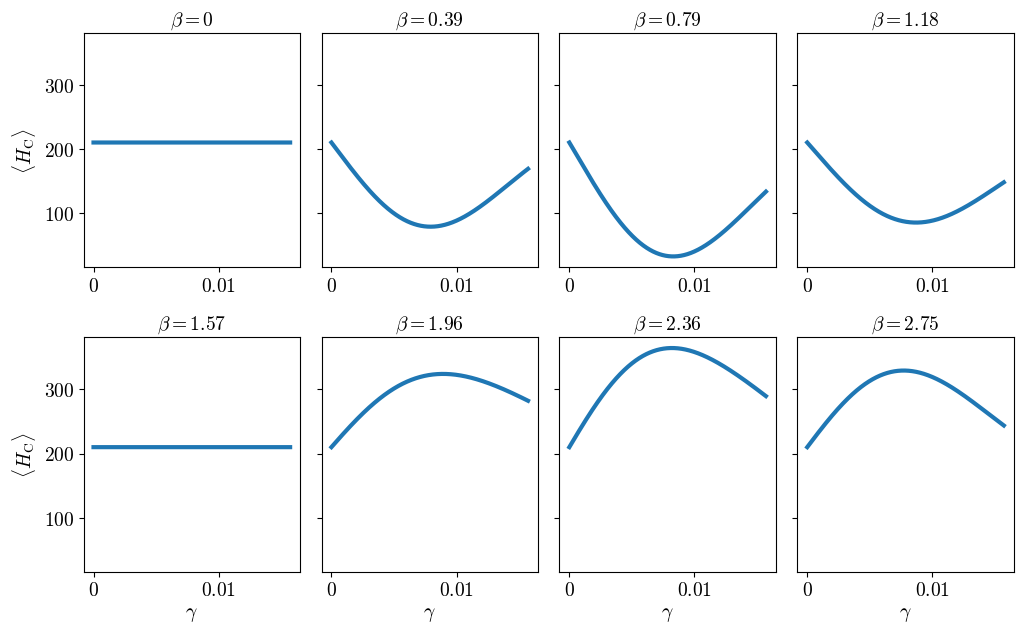

In [16]:
solver = QAOASolver(21, problem_hamiltonian='quadratic_H', cost_hamiltonian='quadratic_H')

# Max angle
max_gamma = 2*np.pi/max(solver.Ep)
print(max_gamma)

gammas = np.linspace(0, max_gamma, 10000)
betas = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8]

fig, axs = plt.subplots(2, 4, figsize=(12,7), sharey=True, sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3,wspace=0.1)

for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost([gamma, beta])
        cost.append(res)

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})

    
    axs[i].plot('gamma', 'cost', data=df, linewidth=3)
    axs[i].set_title(f'$\\beta = {round(beta, 2)}$', fontsize=14)
    if i in [0,4]:
        axs[i].set_ylabel('$\\langle H_\mathrm{{C}} \\rangle$')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

    axs[i].xaxis.set_major_formatter(ticks_formatter)
    axs[i].yaxis.set_major_formatter(ticks_formatter)

# fig.savefig('plots/costfun_landscape.pdf', format='pdf', bbox_inches='tight')

## Optimizer Comparison

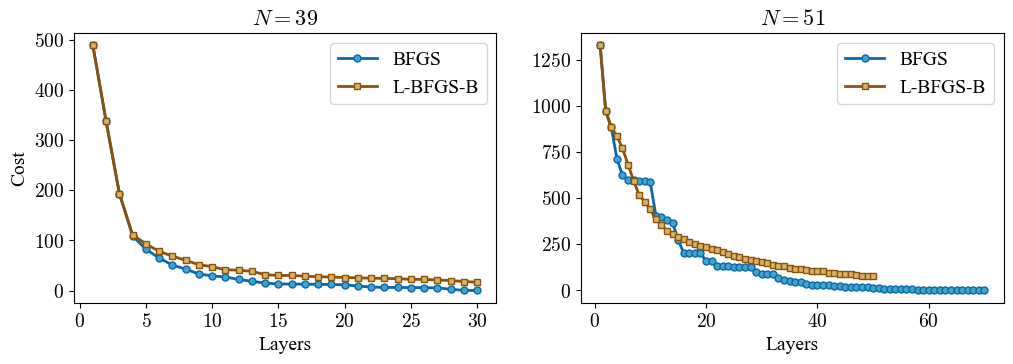

In [17]:
Ns = [39,51]

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))

for j, N in enumerate(Ns):
    ax = axs.flatten()[j]
    df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
    max_layers = int(df['layers'].max())

    for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
        df_i = df[df['optimizer']==optimizer]
        ax.plot(
            'layers', 'cost', data=df_i, label=optimizer,
            color=plot_colors[i+7][0],
            marker=markers[i], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[i+7][0], mfc=plot_colors[i+7][1]
        )

    ax.set_xlabel('Layers')
    if j==0:
        ax.set_ylabel('Cost')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

# plt.savefig('plots/optimizer_comparison.pdf', format='pdf', bbox_inches='tight')

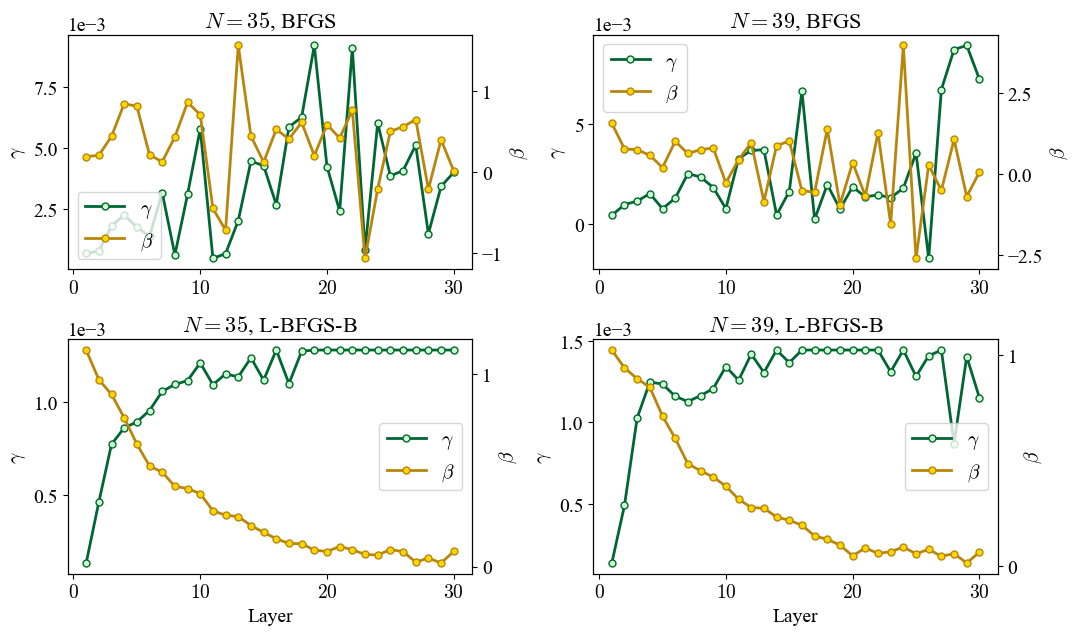

In [19]:
Ns = [35,39]

fig, axs = plt.subplots(2, 2, figsize=(12, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, N in enumerate(Ns):
    df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
    max_layers = int(df['layers'].max())

    for j, optimizer in enumerate(sorted(df['optimizer'].unique())):
        ax = axs[j][i]
        df_i = df[df['optimizer']==optimizer]
        max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
        max_layer = df_i.loc[max_layer_idx, 'layers']
        gammas = df_i.loc[max_layer_idx, 'gammas']
        betas = df_i.loc[max_layer_idx, 'betas']
        
        ax.plot(
            range(1, max_layer+1), gammas, label='$\\gamma$',
            color=plot_colors[3][0],
            marker='o', markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[3][0], mfc=plot_colors[3][1])
        
        twin = ax.twinx()
        twin.plot(
            range(1, max_layer+1), betas, label='$\\beta$',
            color=plot_colors[4][0],
            marker='o', markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[4][0], mfc=plot_colors[4][1])
        
        if j==1:
            ax.set_xlabel('Layer')
        
        ax.set_ylabel('$\\gamma$')
        twin.set_ylabel('$\\beta$')

        ax.set_title(f'$N = {N}$, {optimizer}')
        ax.xaxis.set_major_formatter(ticks_formatter)

        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,1))
        ax.locator_params(axis='y',nbins=2)
        twin.locator_params(axis='y',nbins=2)
        
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = twin.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='center right' if optimizer=='L-BFGS-B'
                  else 'upper left' if N==39 else 'lower left')
        
# plt.savefig('plots/optimizer_parameters_comparison.pdf', format='pdf', bbox_inches='tight')

## Results

### Best fidelities (aux)

First, let's see the maximum fidelities achieved by the different protocols.

In [20]:
df = experiment_results[experiment_results['optimizer']=='BFGS']
max_fidelities = df.groupby(['N','setup'])['fidelity'].max()
df = df.merge(max_fidelities, how='inner', on=['N','setup', 'fidelity'])
df.groupby(['N', 'setup']).agg({
    'layers': 'min',
    'num_2qub_gates': 'min',
    'fidelity': 'first',
}).pivot_table(values='fidelity', index='setup', columns='N')

N,15,21,25,35,39,51,77,87,95,115,119,143
setup,,,,,,,,,,,,
linear_abs,1.0,1.0,1.0,0.996695,0.999976,0.992734,0.985991,0.979239,0.849321,0.870027,0.911881,0.949632
linear_quadratic,1.0,1.0,1.0,0.968217,0.999791,1.000000,0.944180,0.666109,0.156931,0.006714,0.430948,0.012796
standard,1.0,1.0,1.0,0.864901,0.982655,1.000000,0.401879,0.103895,0.180864,0.050182,0.078508,0.079862


### Cost vs Layers

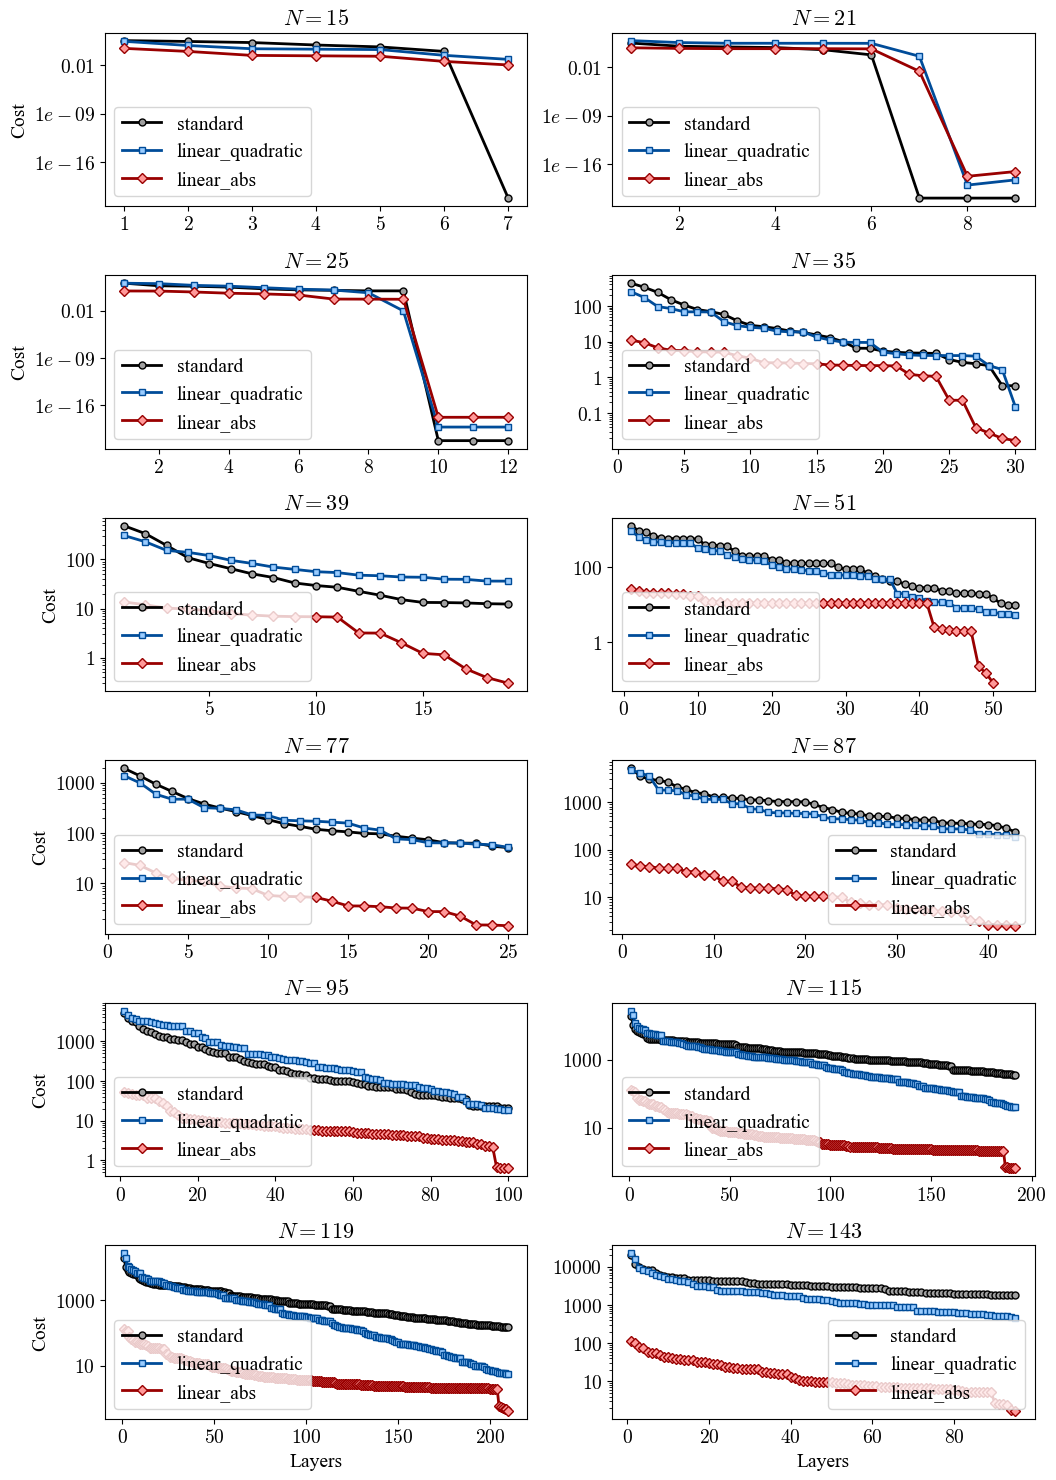

In [21]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
        .reset_index().loc[0,'layers'] + 5
    
    df_N = df_N[df_N['layers']<=max_layers]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'cost', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    if i>=len(Ns)-2:
        ax.set_xlabel('Layers')
    ax.set_yscale('log')
    if i%ncols==0:
        ax.set_ylabel('Cost')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

# plt.savefig('plots/cost_layers_all.pdf', format='pdf', bbox_inches='tight')

### Normalized Cost vs Layers

Cost given by $\langle |H_\mathrm{LP}| \rangle$ is not directly comparable with the cost given by
$\langle H_\mathrm{QP} \rangle$. Given a state $\ket{\psi}$,
$$\langle |H_\mathrm{LP}|^2 \rangle_\psi = \langle H_\mathrm{QP} \rangle_\psi \Longrightarrow
\langle |H_\mathrm{LP}| \rangle_\psi^2 \neq \langle H_\mathrm{QP} \rangle_\psi$$
so we cannot just square the cost when using the linear\_abs protocol to compare it to the standard protocol.

Instead, we can perform a cross-evaluation. That is, for the linear\_abs protocol, we compute the cost that we
would have obtained for the linear\_quadratic or standard protocol, i.e. $\langle H_\mathrm{QP} \rangle$, given that we have access to the state.

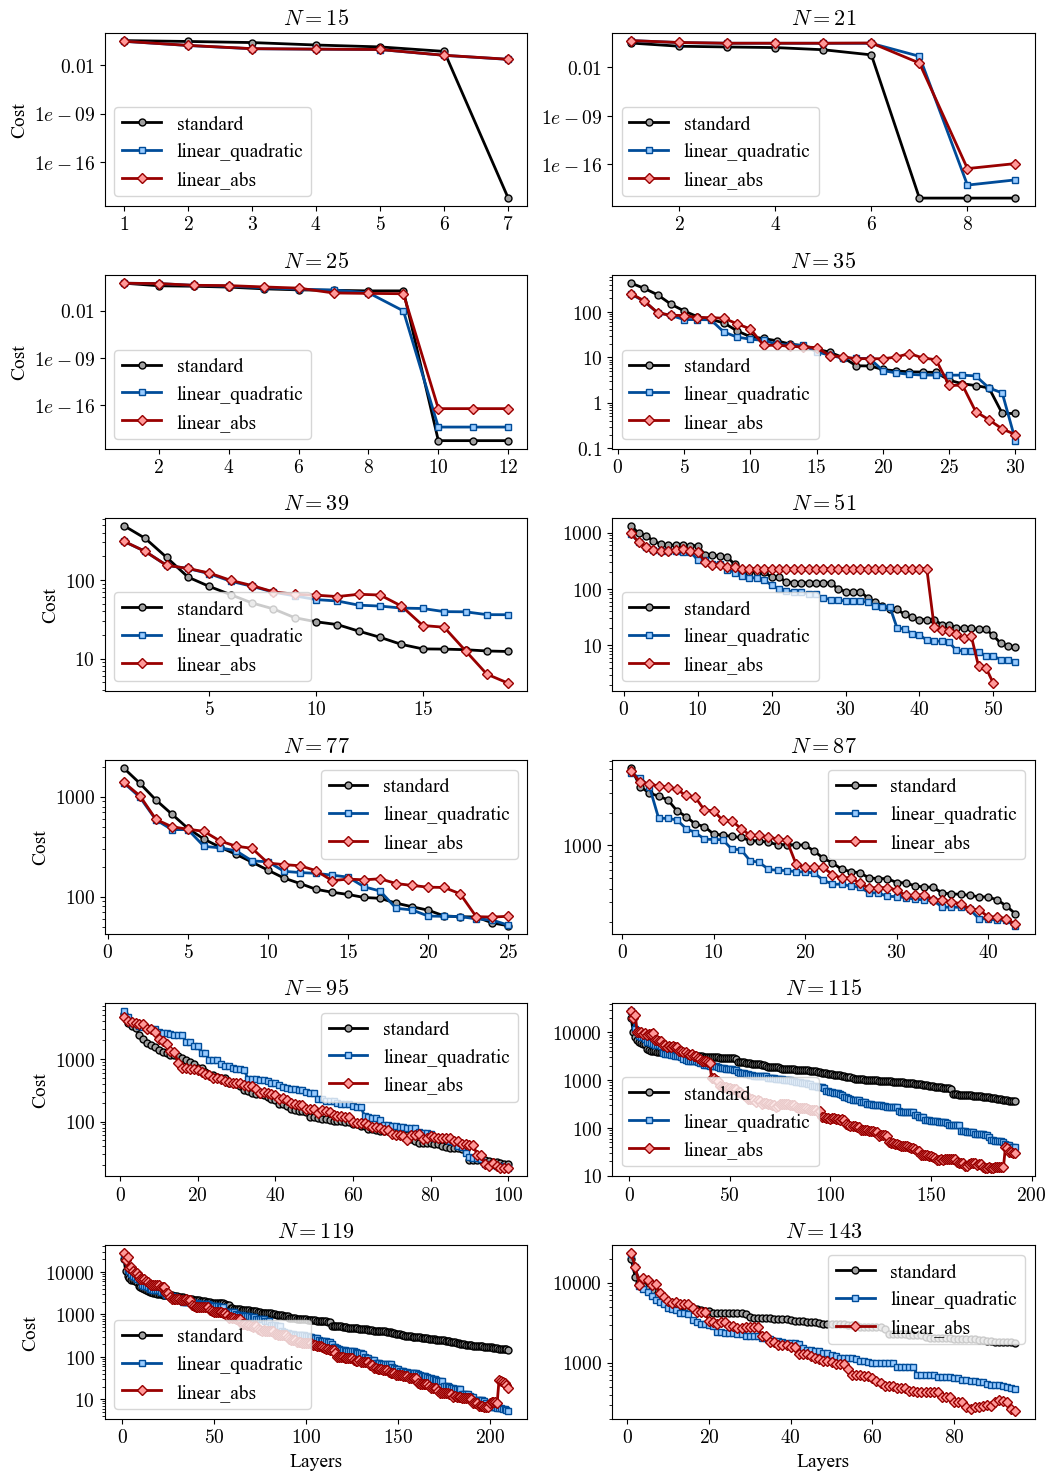

In [22]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
        .reset_index().loc[0,'layers'] + 5
    
    df_N = df_N[df_N['layers']<=max_layers]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'normalized_cost', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    if i>=len(Ns)-2:
        ax.set_xlabel('Layers')
    ax.set_yscale('log')
    if i%ncols==0:
        ax.set_ylabel('Cost')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

# plt.savefig('plots/cost_layers_raw.pdf', format='pdf', bbox_inches='tight')

### Fidelity (success probability) vs Layers

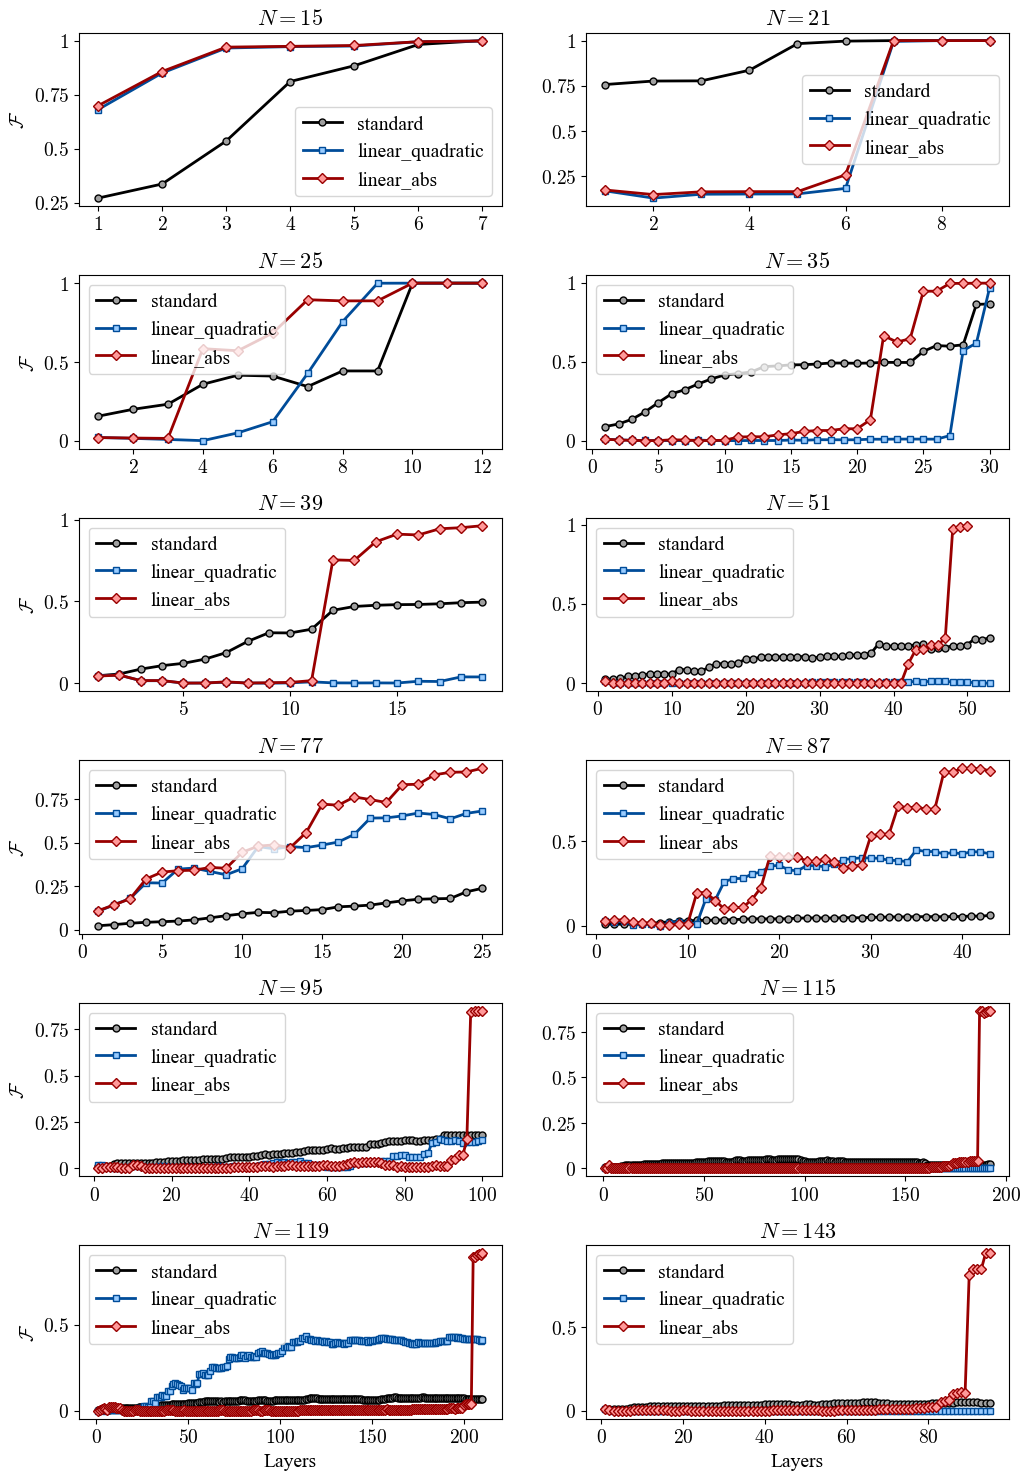

In [23]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
        .reset_index().loc[0,'layers'] + 5
    
    df_N = df_N[df_N['layers']<=max_layers]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        
        ax.plot(
            'layers', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    if i>=len(Ns)-2:
        ax.set_xlabel('Layers')
    if i%ncols==0:
        ax.set_ylabel('$\mathcal{F}$')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

# plt.savefig('plots/fidelity_layers_all.pdf', format='pdf', bbox_inches='tight')

### Normalized Cost vs Gates (log scale)

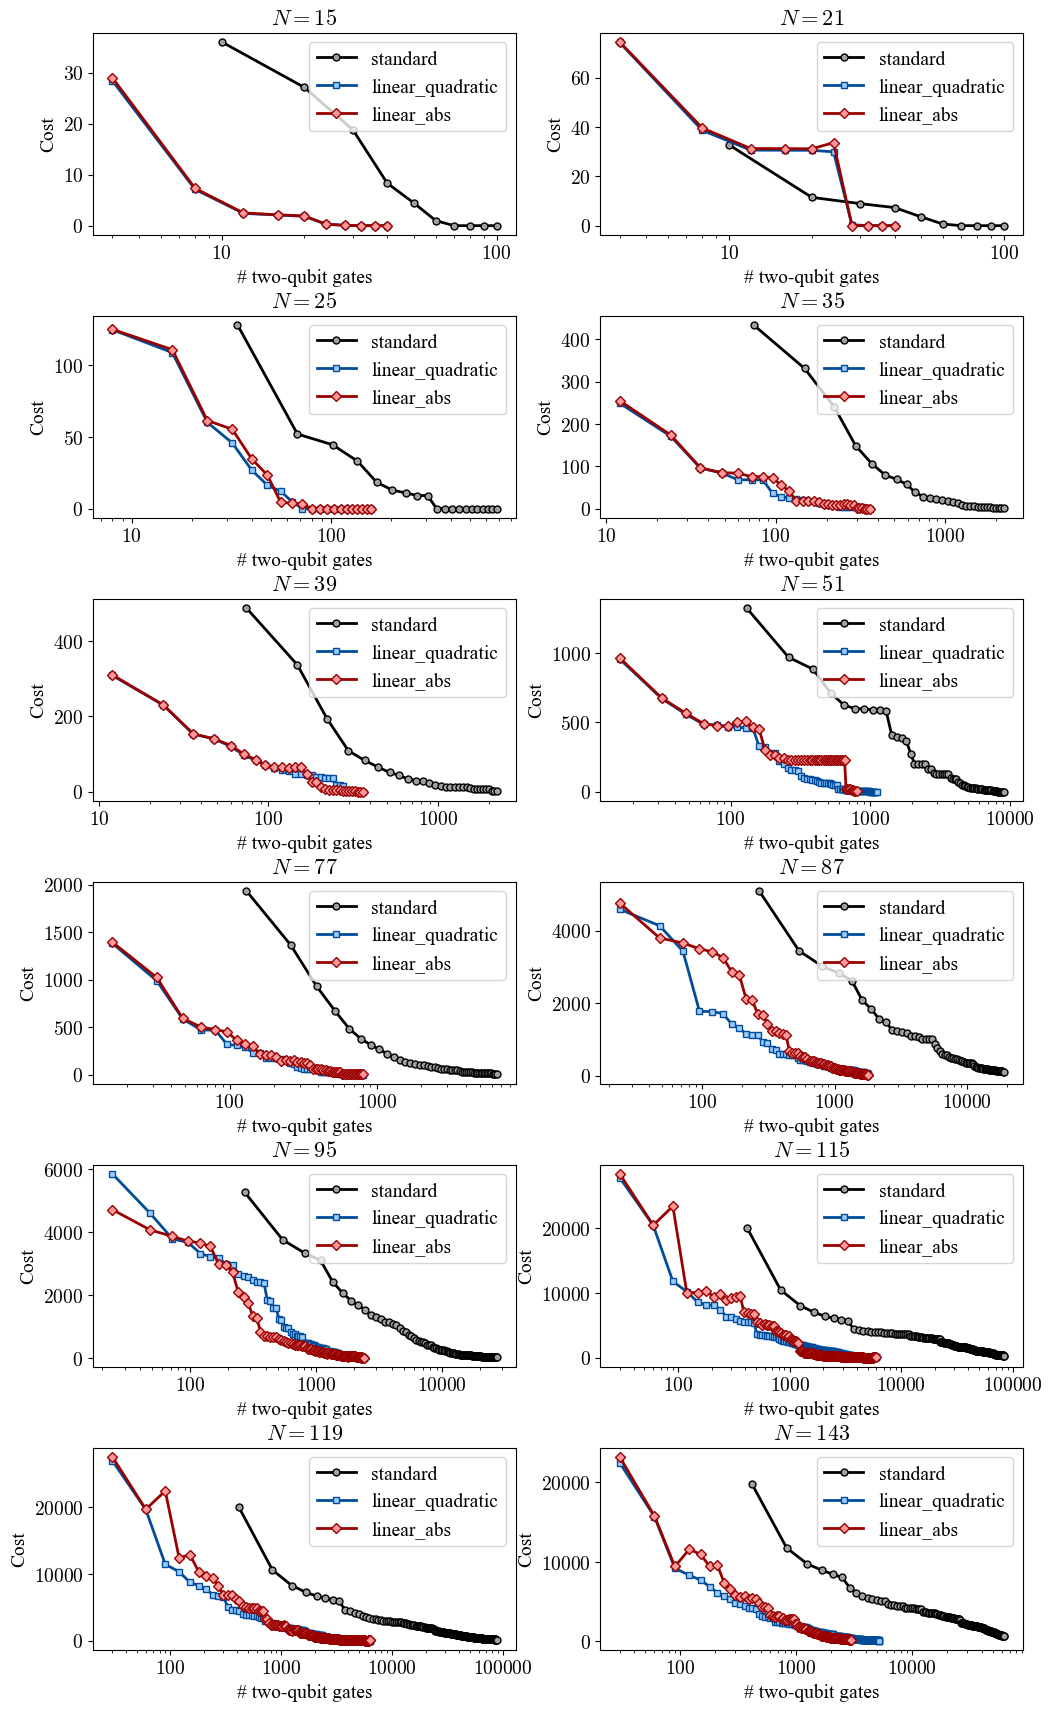

In [24]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'num_2qub_gates', 'normalized_cost', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )
        ax.set_xscale('log')

    ax.set_xlabel('# two-qubit gates')
    if j%2==0:
        ax.set_ylabel('Cost')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

#plt.savefig('plots/cost_gates_raw_logscale.pdf', format='pdf', bbox_inches='tight')

### Fidelity (success probability) vs Gates (log scale)

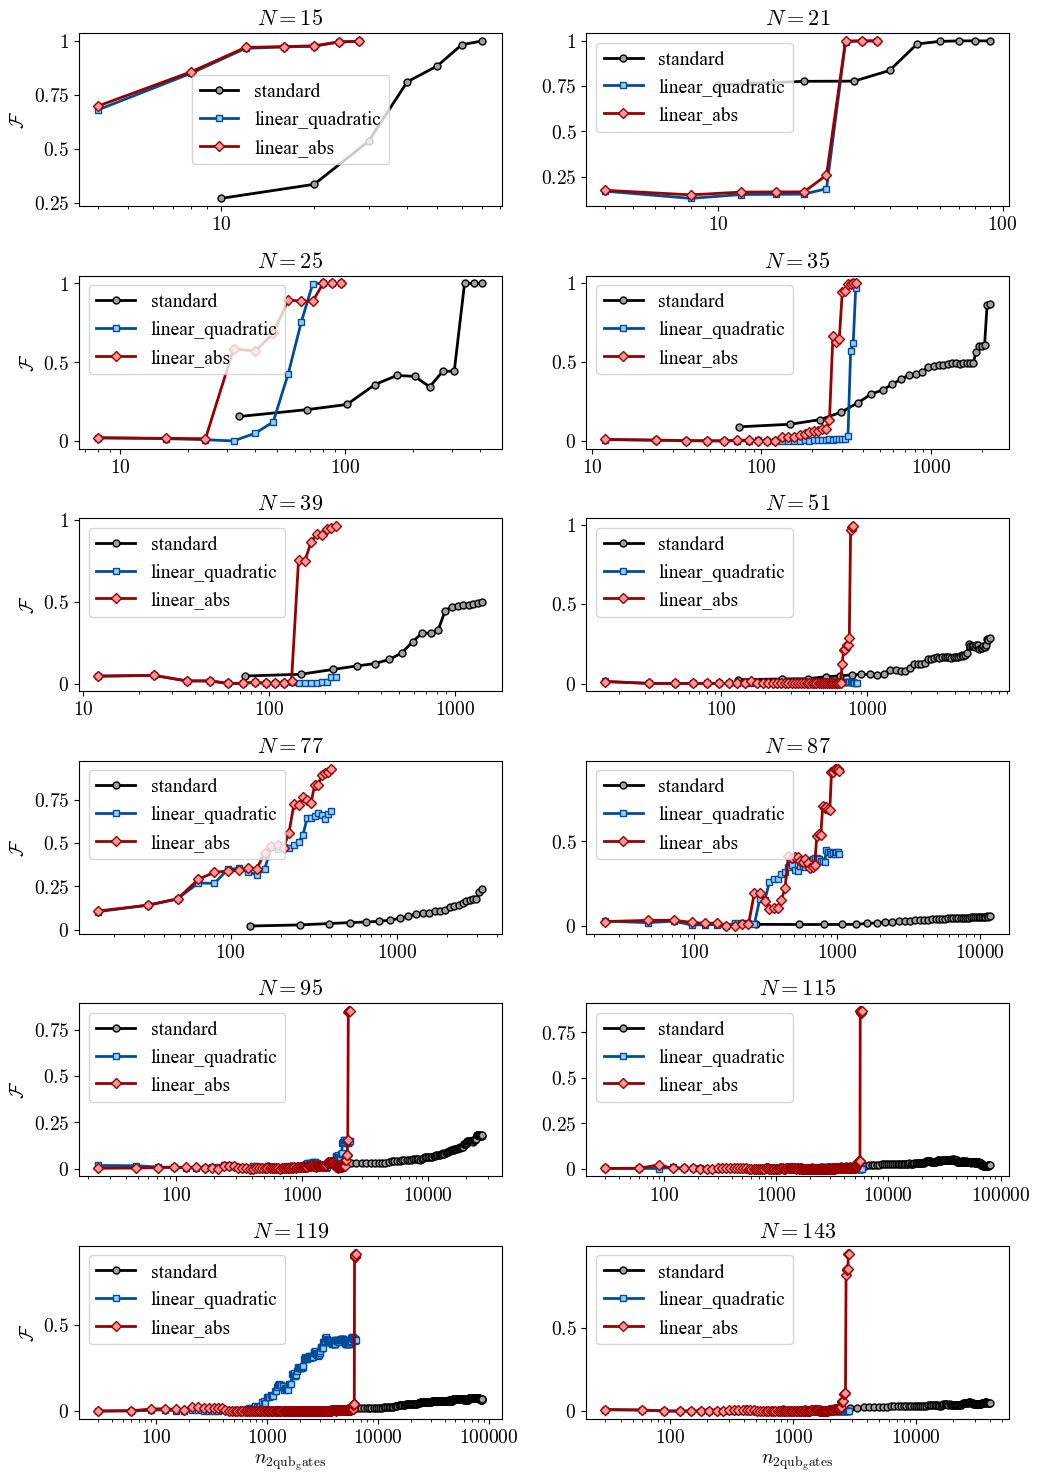

In [25]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
        .reset_index().loc[0,'layers'] + 5
    
    df_N = df_N[df_N['layers']<=max_layers]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'num_2qub_gates', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )
        ax.set_xscale('log')

    if i>=len(Ns)-2:
        ax.set_xlabel('$n_\mathrm{2qub_gates}$')
    if i%2==0:
        ax.set_ylabel('$\mathcal{F}$')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

# plt.savefig('plots/fidelity_gates_all.pdf', format='pdf', bbox_inches='tight')

### Why these suddent jumps in fidelity when using the linear protocol?

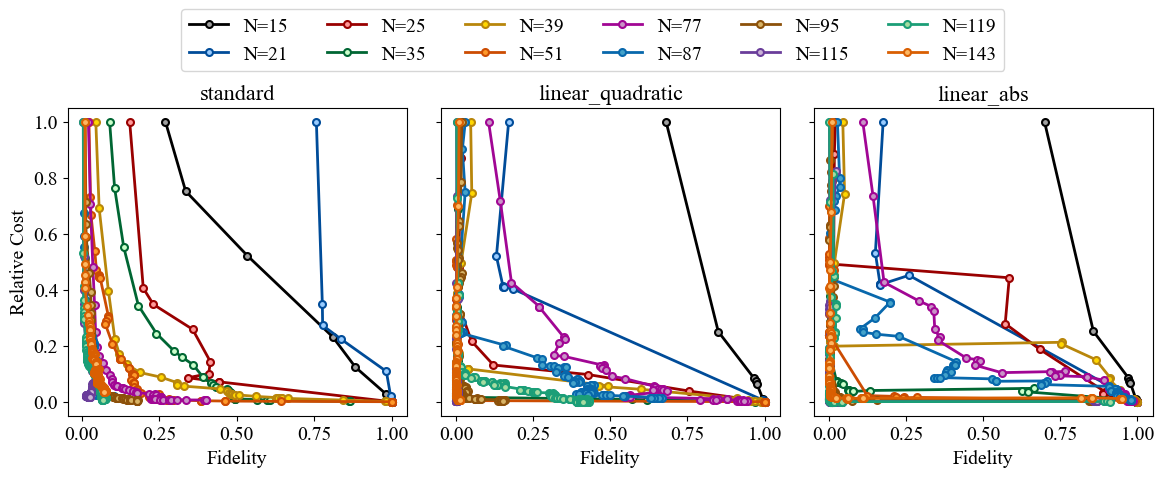

In [26]:
fig, axs = plt.subplots(1,3, figsize=(14,4), sharey=True)
fig.subplots_adjust(wspace=0.1)

for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    ax = axs[j]
    df = experiment_results[(experiment_results['setup']==setup)
                            & (experiment_results['optimizer']=='BFGS')]
    df = df.groupby(['N','layers']).last().reset_index()
    Ns = sorted(df['N'].unique())

    for i, N in enumerate(Ns):
        df_N = df[df['N']==N]
        ax.plot(df_N['fidelity'], df_N['relative_cost'], label=f'N={N}',
                color=plot_colors[i][0], mec=plot_colors[i][0], mfc=plot_colors[i][1], marker='.',
                markersize=10, linewidth=2)

    ax.set_xlabel('Fidelity')
    ax.set_title(setup)
    if j==0:
        ax.set_ylabel('Relative Cost')
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=6);

Linear Hamiltonian's spectrum for N=15 has 6 positive and 1 negative eigenvalues
Linear Hamiltonian's spectrum for N=21 has 7 positive and 0 negative eigenvalues
Linear Hamiltonian's spectrum for N=25 has 12 positive and 3 negative eigenvalues
Linear Hamiltonian's spectrum for N=35 has 19 positive and 11 negative eigenvalues
Linear Hamiltonian's spectrum for N=39 has 21 positive and 10 negative eigenvalues
Linear Hamiltonian's spectrum for N=51 has 33 positive and 30 negative eigenvalues
Linear Hamiltonian's spectrum for N=77 has 42 positive and 21 negative eigenvalues
Linear Hamiltonian's spectrum for N=87 has 60 positive and 67 negative eigenvalues
Linear Hamiltonian's spectrum for N=95 has 64 positive and 63 negative eigenvalues
Linear Hamiltonian's spectrum for N=115 has 89 positive and 166 negative eigenvalues
Linear Hamiltonian's spectrum for N=119 has 93 positive and 162 negative eigenvalues
Linear Hamiltonian's spectrum for N=143 has 104 positive and 150 negative eigenvalues


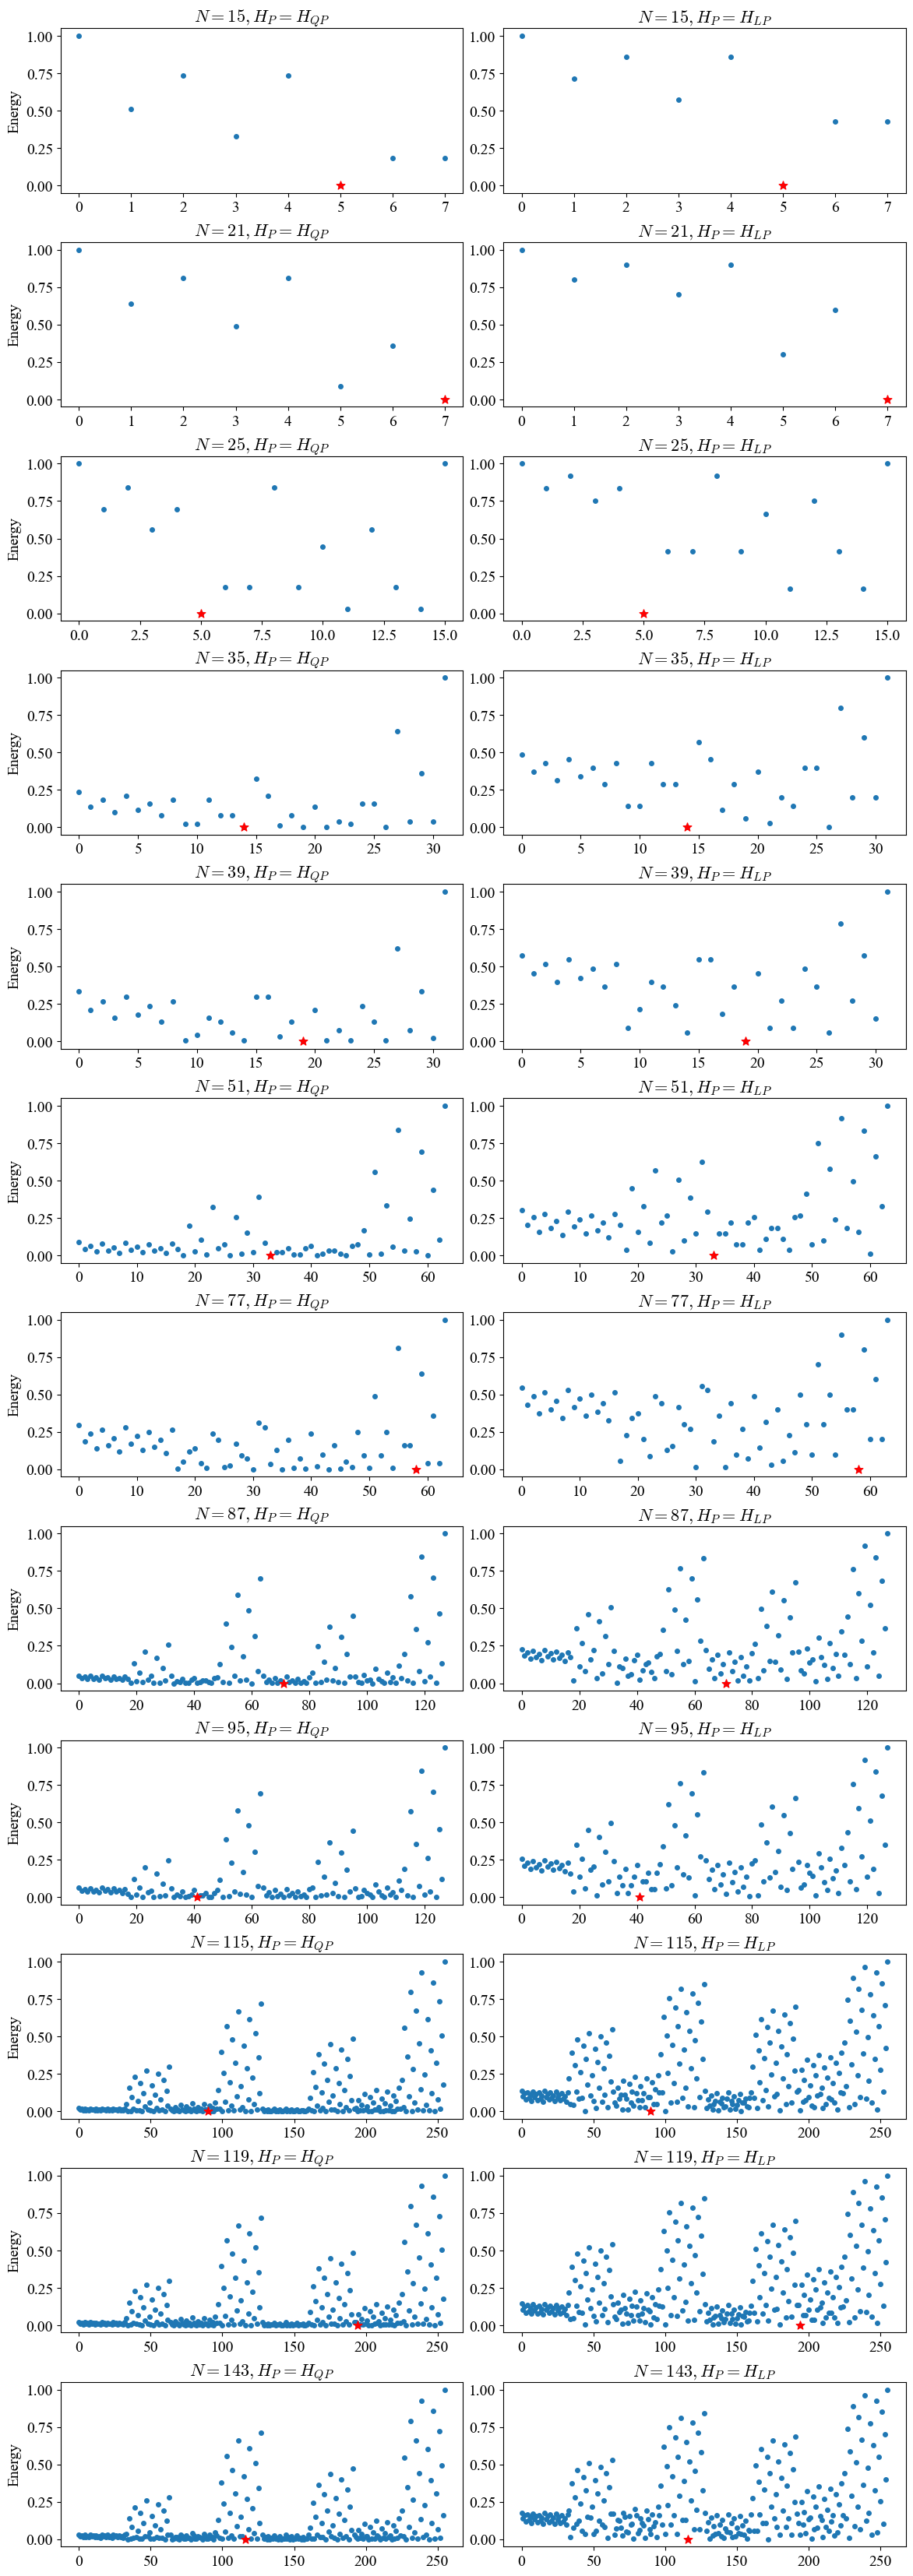

In [27]:
Ns = sorted(experiment_results['N'].unique())

fig, axs = plt.subplots(len(Ns), 2, figsize=(14,3.5*len(Ns)))
fig.subplots_adjust(wspace=0.1, hspace=0.3)

for i, N in enumerate(Ns):
    for j, setup in enumerate(['standard', 'linear_quadratic']):
        ax = axs[i][j]
        df = experiment_results[(experiment_results['N']==N)
                                &(experiment_results['setup']==setup)
                                & (experiment_results['optimizer']=='BFGS')].reset_index()
        Ep = df.loc[0,'Ep']
        R = np.max(np.abs(Ep))
        normalized_Ep = np.abs(Ep)/R
        title = f'$N={N}, H_P=H_{{{"Q" if setup=="standard" else "L"}P}}$'
        ax.scatter(range(len(Ep)), normalized_Ep, s=16)

        sol = list(normalized_Ep).index(0)
        ax.scatter(sol, 0, s=64, color='red', marker='*')

        if setup=='linear_quadratic':
            print(f"Linear Hamiltonian's spectrum for N={N} has {len(list(filter(lambda e: e>0, Ep)))} positive and {len(list(filter(lambda e: e<0, Ep)))} negative eigenvalues")

        ax.set_title(title)
        if j==0:
            ax.set_ylabel('Energy')

In [28]:
df = experiment_results[(experiment_results['setup'].isin(['standard', 'linear_quadratic']))
                        & (experiment_results['optimizer']=='BFGS')
                        & (experiment_results['layers']==1)][['N', 'problem_hamiltonian', 'Ep']]

df['abs_Ep'] = df['Ep'].apply(lambda Ep: np.abs(Ep))
df['R'] = df['abs_Ep'].apply(lambda e: np.max(e))
df['gap0'] = df['abs_Ep'].apply(lambda e: np.min(e[e>0]))
df['rms'] = df['Ep'].apply(lambda e: np.sqrt(np.mean(e**2)))
df['rms_over_R'] = df['rms'] / df['R']
df['rescaled_gap'] = df['gap0'] / df['R']

In [29]:
df[['N', 'problem_hamiltonian', 'rescaled_gap']].sort_values(['N', 'problem_hamiltonian'])\
    .pivot_table(index='problem_hamiltonian', columns='N', values='rescaled_gap')

N,15,21,25,35,39,51,77,87,95,115,119,143
problem_hamiltonian,,,,,,,,,,,,
linear_H,0.428571,0.30,0.166667,0.028571,0.060606,0.012048,0.014286,0.005291,0.005405,0.002410,0.002421,0.002494
quadratic_H,0.183673,0.09,0.027778,0.000816,0.003673,0.000145,0.000204,0.000028,0.000029,0.000006,0.000006,0.000006


In [30]:
df[['N', 'problem_hamiltonian', 'rms_over_R']].sort_values(['N', 'problem_hamiltonian'])\
    .pivot_table(index='problem_hamiltonian', columns='N', values='rms_over_R')

N,15,21,25,35,39,51,77,87,95,115,119,143
problem_hamiltonian,,,,,,,,,,,,
linear_H,0.677631,0.724569,0.679563,0.396412,0.431220,0.342580,0.406202,0.316157,0.316228,0.319607,0.318607,0.313605
quadratic_H,0.560575,0.622455,0.577121,0.253806,0.272507,0.229974,0.245677,0.204039,0.201332,0.208262,0.207426,0.202505


Both metrics show that the energy spectrum of linear_H is more spread than quadratic_H. Then, it makes sense that linear_H induces less transitions to the zero-energy state at the beginning. If first accumulate populations in states near the zero-energy state, and then suddenly induces transitions from these to the solution.

### Sorted probability distributions

For this visualization, we need to fix something: e.g., number of layers

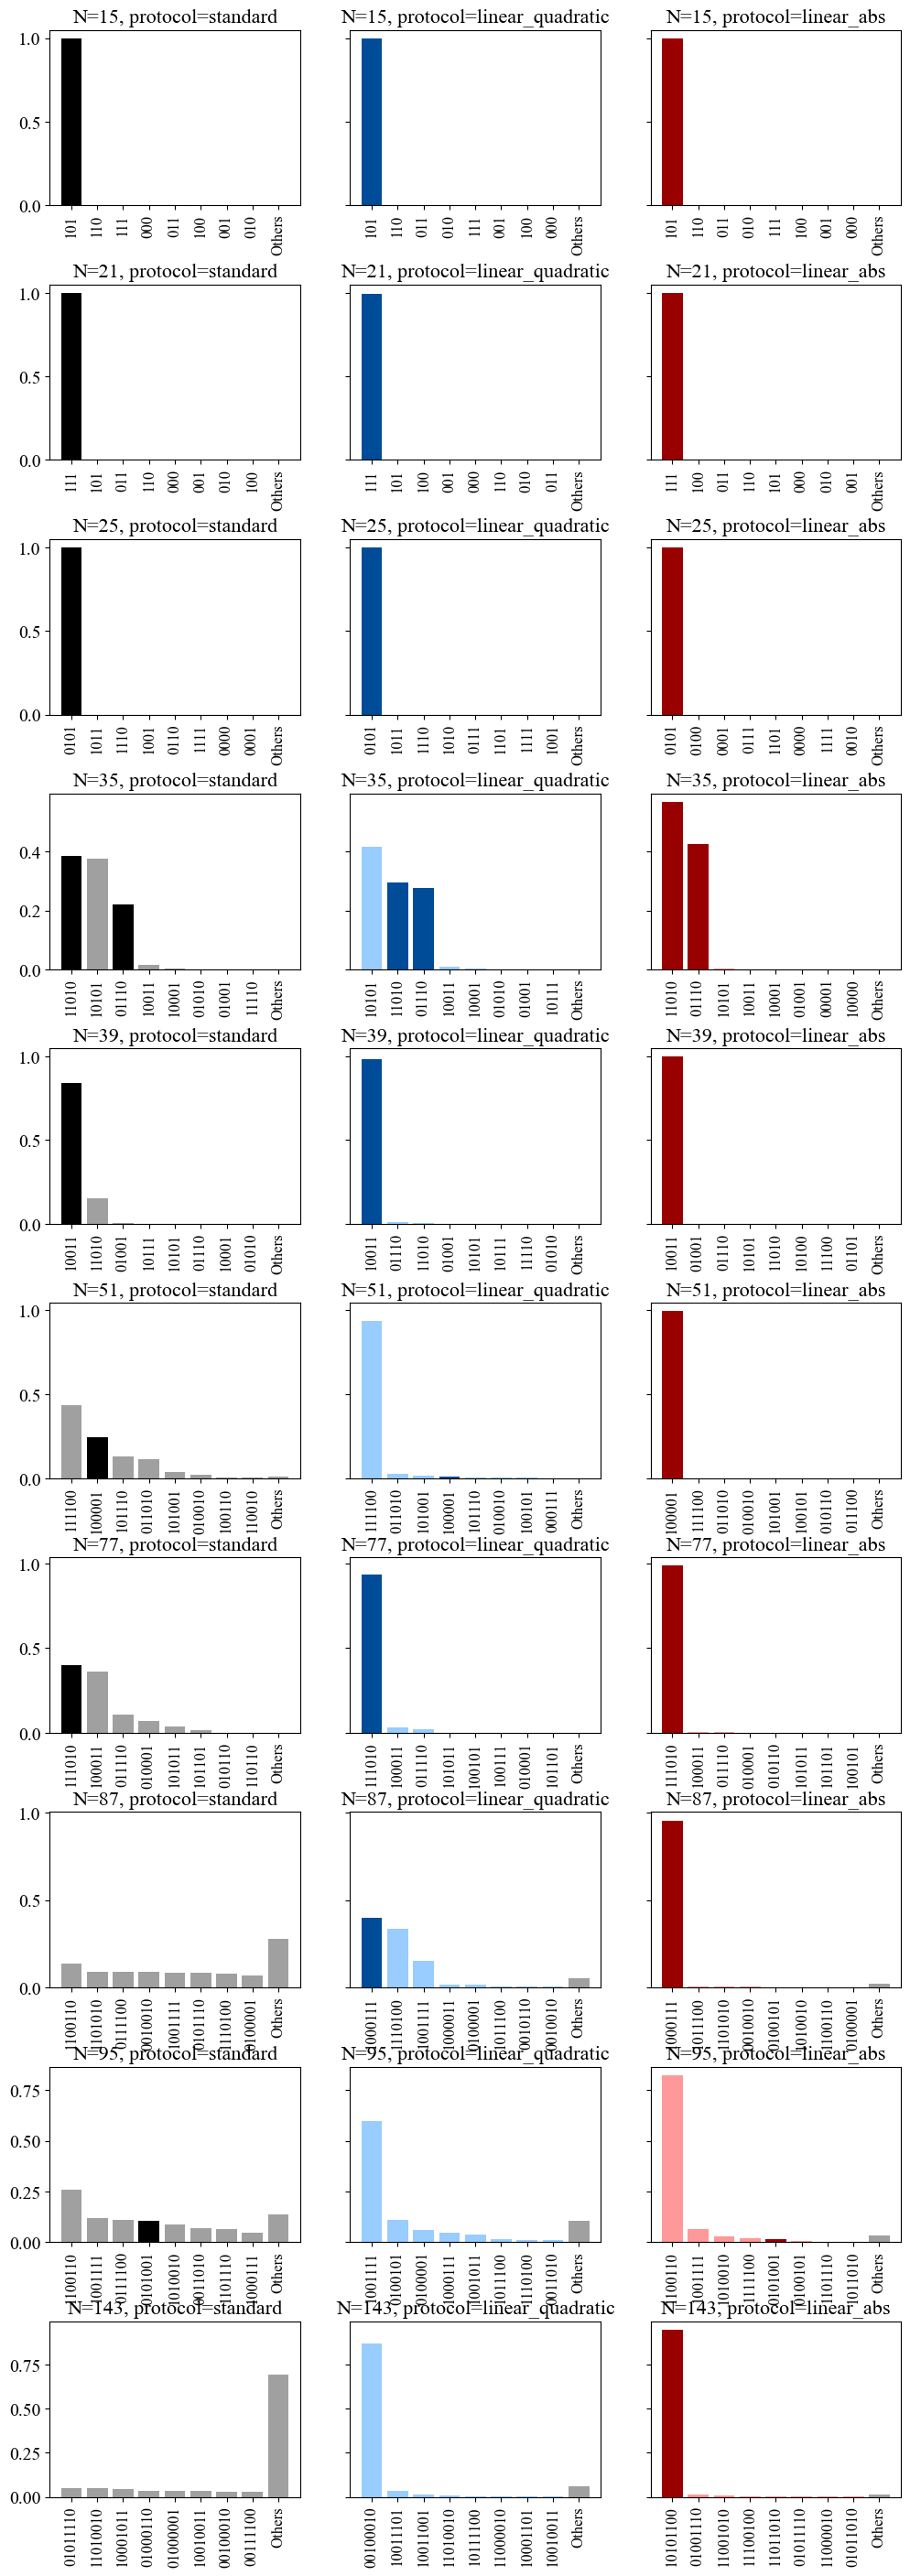

In [31]:
num_qubits_layers = {
    3: 7,
    4: 10,
    5: 28,
    6: 50,
    7: 60,
    8: 100
}

Ns = sorted(experiment_results[(experiment_results['N']!=115)&(experiment_results['N']!=119)]['N'].unique())

ncols = 3
nrows = len(Ns)

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey='row')
fig.subplots_adjust(hspace=0.45)

for i, N in enumerate(Ns):
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        ax = axs[i][j]
        df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')
                        & (experiment_results['setup']==protocol)].copy()
        df['plot_layers'] = df['num_qubits'].map(num_qubits_layers)
        df = df[df['layers']==df['plot_layers']].reset_index()
        probs = np.array(df.loc[0, 'populations'])
        num_qubits = df.loc[0, 'num_qubits']
        solutions = df.loc[0, 'solution']
        x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
        idx_sorted = np.argsort(probs)[::-1]
        
        # Select top 8
        top_k = 8
        idx_top = idx_sorted[:top_k]
        idx_rest = idx_sorted[top_k:]
        
        # Build reduced x and y
        x_top = [x_hist[k] for k in idx_top]
        y_top = probs[idx_top]
        
        # Add the "Others" bar
        x_plot = x_top + ['Others']
        y_plot = list(y_top) + [probs[idx_rest].sum()]
        
        # Colors: dark if solution, light otherwise, gray for "Others"
        bar_colors = [
            plot_colors[j][0] if label in solutions else plot_colors[j][1]
            for label in x_top
        ] + ['#A0A0A0']  # gray for "Others"

        ax.bar(x_plot, y_plot, color=bar_colors)
        ax.xaxis.set_tick_params(rotation=90, labelsize=12)
        ax.set_title(f'N={N}, protocol={protocol}')

### Density plots

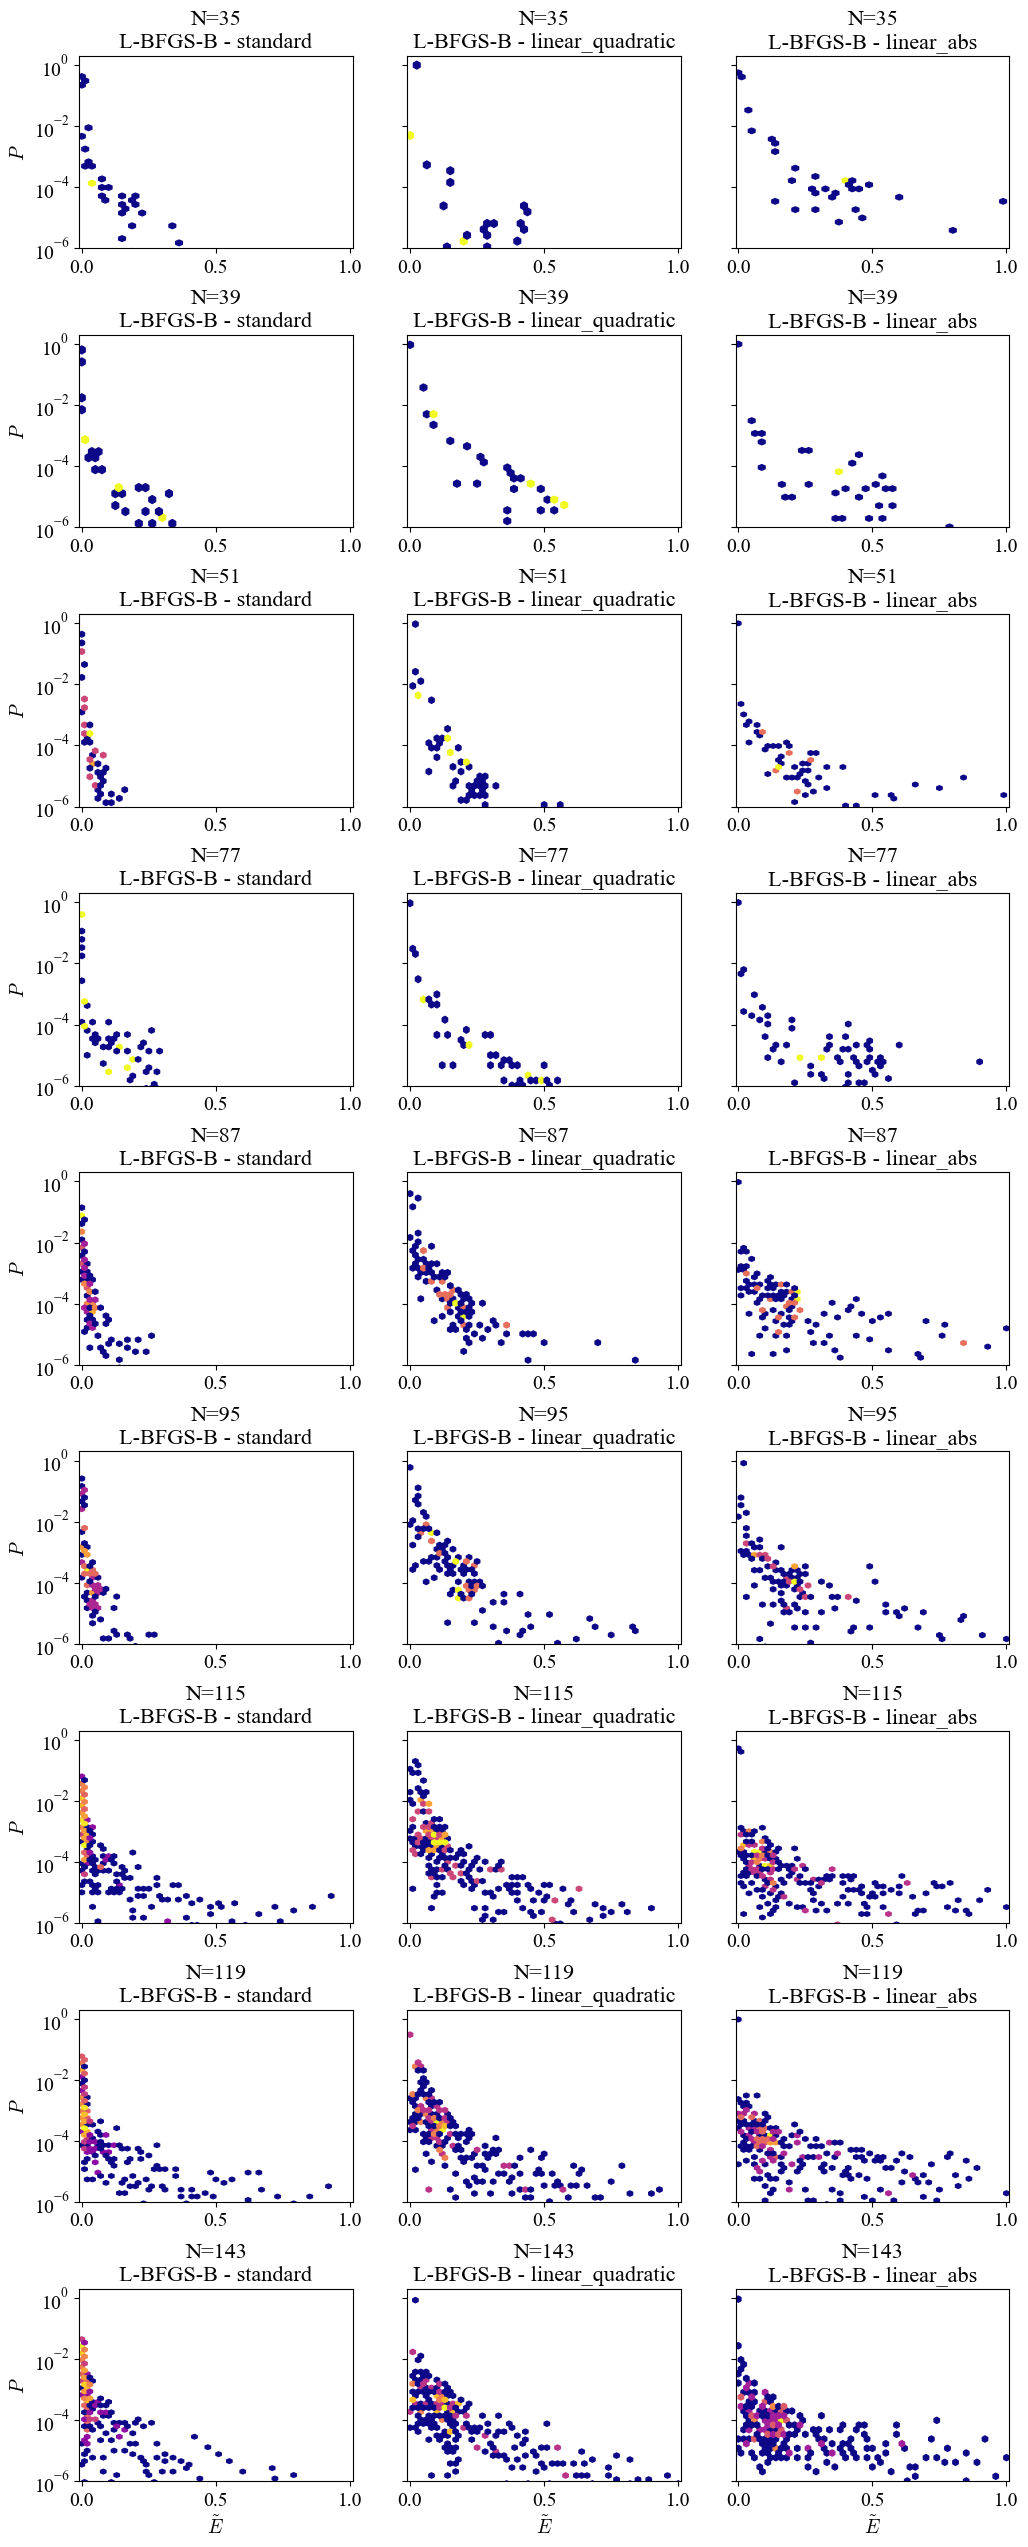

In [32]:
num_qubits_layers = {
    3: 7,
    5: 25,
    6: 50,
    7: 60,
    8: 75
}

gridsize_map = {
    3: 30,
    5: 40,
    6: 50,
    7: 50,
    8: 50
}

Ns = sorted(filter(lambda e: e>=35, experiment_results['N'].unique()))

ncols = 3
nrows = len(Ns)

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey='row')
fig.subplots_adjust(hspace=0.45)

for i, N in enumerate(Ns):
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        ax = axs[i][j]
        df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')
                        & (experiment_results['setup']==protocol)].copy()
        df['plot_layers'] = df['num_qubits'].map(num_qubits_layers)
        df = df[df['layers']==df['plot_layers']].reset_index()
        probs = np.array(df.loc[0, 'populations'])
        energies = np.abs(np.array(df.loc[0, 'normalized_Ep']))

        num_qubits = df.loc[0, 'num_qubits']
        hb = ax.hexbin(energies, probs, gridsize=gridsize_map[num_qubits], cmap='plasma', bins='log', yscale='log')
        ax.set_title(f"N={N}\n{optimizer} - {protocol}")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,2)
        if j == 0:
            ax.set_ylabel('$P$')
        if i == len(Ns)-1:
            ax.set_xlabel('$\\tilde{E}$')

### No. two-qubit gates to success vs $N$

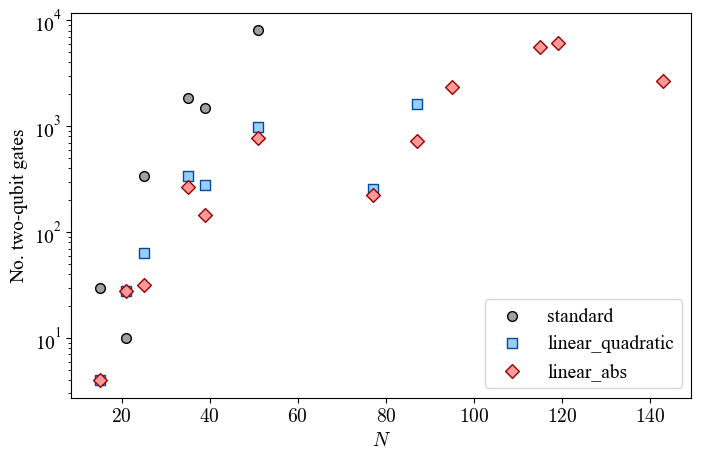

In [33]:
df = experiment_results[experiment_results['optimizer']=='BFGS']
df = df[df['fidelity']>=0.5]
df = df.groupby(['N', 'setup'])['num_2qub_gates'].min().reset_index()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, setup in enumerate(['standard','linear_quadratic','linear_abs']):
    ax.scatter('N', 'num_2qub_gates', data=df[df['setup']==setup], label=setup,
            color=plot_colors[i][0], marker=markers[i], s=49,
            edgecolor=plot_colors[i][0], facecolor=plot_colors[i][1])
    
ax.legend(loc='best')
ax.set_xlabel('$N$')
ax.set_ylabel('No. two-qubit gates')
ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)
ax.set_yscale('log')

### No. two-qubit gates to success vs problem size

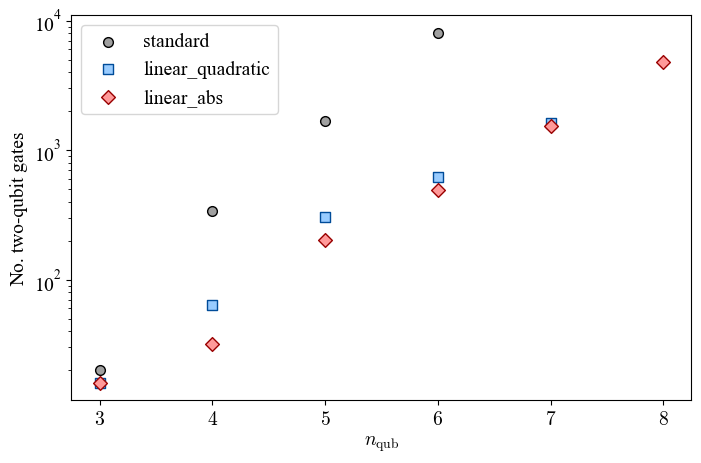

In [34]:
df = experiment_results[experiment_results['optimizer']=='BFGS']
df = df[df['fidelity']>=0.5]
df = df.groupby(['num_qubits', 'N', 'setup'])['num_2qub_gates'].min().reset_index()
df = df.groupby(['num_qubits', 'setup']).agg(
    num_2qub_gates_mean=('num_2qub_gates', 'mean')
).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, setup in enumerate(['standard','linear_quadratic','linear_abs']):
    ax.scatter('num_qubits', 'num_2qub_gates_mean', data=df[df['setup']==setup], label=setup,
            color=plot_colors[i][0], marker=markers[i], s=49,
            edgecolor=plot_colors[i][0], facecolor=plot_colors[i][1])
    
ax.legend(loc='best')
ax.set_xlabel('$n_\mathrm{qub}$')
ax.set_ylabel('No. two-qubit gates')
ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)
ax.set_yscale('log')

### Probability below energy threshold (< 5%)

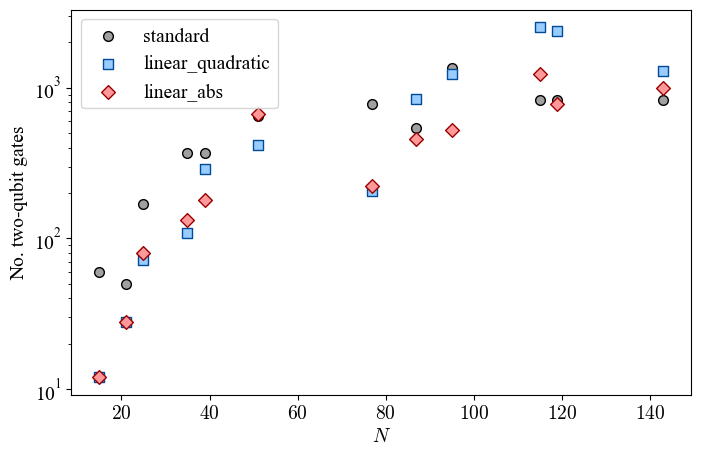

In [35]:
alpha = 0.05

df = experiment_results[experiment_results['optimizer']=='BFGS'].copy()
df = df[['N', 'layers', 'num_2qub_gates', 'setup', 'relative_cost',
         'fidelity', f'm_alpha_{alpha}']]
df = df[df[f'm_alpha_{alpha}'] >= mass_threshold]
df = df.groupby(['N','setup']).agg({
    'layers': 'min',
    'num_2qub_gates': 'min',
    'm_alpha_0.05': 'first'
}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, setup in enumerate(['standard','linear_quadratic','linear_abs']):
    ax.scatter('N', 'num_2qub_gates', data=df[df['setup']==setup], label=setup,
            color=plot_colors[i][0], marker=markers[i], s=49,
            edgecolor=plot_colors[i][0], facecolor=plot_colors[i][1])
    
ax.legend(loc='best')
ax.set_xlabel('$N$')
ax.set_ylabel('No. two-qubit gates')
ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)
ax.set_yscale('log')

### Probability of 5% eigenstates closest to the solution

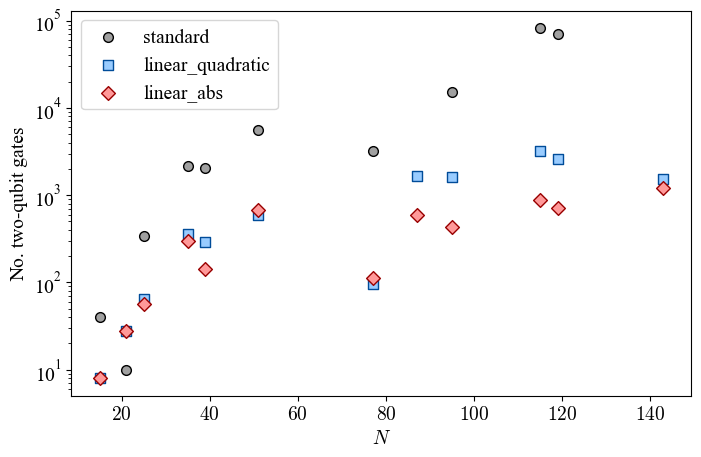

In [36]:
alpha = 0.05
threshold = 0.75

def compute_m_closest(row, alpha):
    Ep = np.array(row['Ep'])
    populations = np.array(row['populations'])
    n_states = len(Ep)
    k = max(1, int(np.ceil(alpha * n_states)))  # number of states to include

    # sort indices by closeness to zero energy
    idx = np.argsort(np.abs(Ep))
    closest_idx = idx[:k]
    return populations[closest_idx].sum()

df = experiment_results[experiment_results['optimizer']=='BFGS'].copy()
# Add the column
df['m_closest_0.05'] = df.apply(lambda row: compute_m_closest(row, alpha), axis=1)

df = df[['N', 'layers', 'num_2qub_gates', 'setup', 'relative_cost',
         'fidelity', 'm_closest_0.05']]
df = df[df['m_closest_0.05'] >= threshold]
df = df.groupby(['N','setup']).agg({
    'layers': 'min',
    'num_2qub_gates': 'min',
    'm_closest_0.05': 'first'
}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, setup in enumerate(['standard','linear_quadratic','linear_abs']):
    ax.scatter('N', 'num_2qub_gates', data=df[df['setup']==setup], label=setup,
               color=plot_colors[i][0], marker=markers[i], s=49,
               edgecolor=plot_colors[i][0], facecolor=plot_colors[i][1])
    
ax.legend(loc='best')
ax.set_xlabel('$N$')
ax.set_ylabel('No. two-qubit gates')
ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)
ax.set_yscale('log')

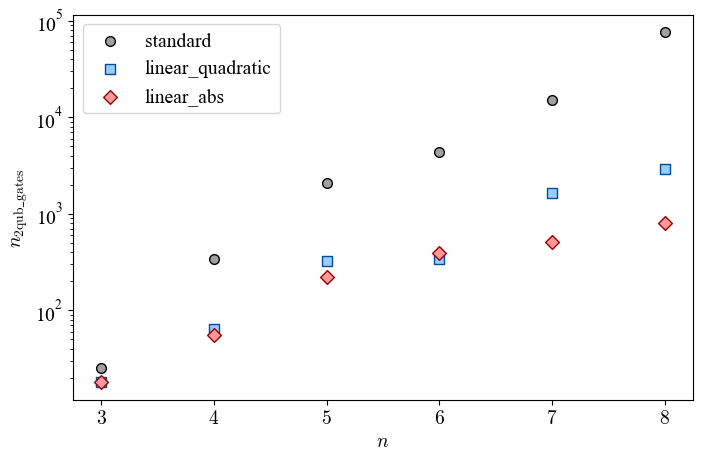

In [37]:
alpha = 0.05
threshold = 0.75

def compute_m_closest(row, alpha):
    Ep = np.array(row['Ep'])
    populations = np.array(row['populations'])
    n_states = len(Ep)
    k = max(1, int(np.ceil(alpha * n_states)))  # number of states to include

    # sort indices by closeness to zero energy
    idx = np.argsort(np.abs(Ep))
    closest_idx = idx[:k]
    return populations[closest_idx].sum()

df = experiment_results[(experiment_results['optimizer']=='BFGS')&(experiment_results['N']!=143)].copy()
# Add the column
df[f'm_closest_{alpha}'] = df.apply(lambda row: compute_m_closest(row, alpha), axis=1)

df = df[['N', 'num_qubits', 'layers', 'num_2qub_gates', 'setup', 'relative_cost',
         'fidelity', f'm_closest_{alpha}']]
df = df[df[f'm_closest_{alpha}'] >= threshold]
df = df.groupby(['N','num_qubits','setup']).agg({
    'layers': 'min',
    'num_2qub_gates': 'min',
    f'm_closest_{alpha}': 'first'
}).reset_index()

df = df.groupby(['num_qubits', 'setup']).agg({
    'num_2qub_gates': 'mean'
}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, setup in enumerate(['standard','linear_quadratic','linear_abs']):
    ax.scatter('num_qubits', 'num_2qub_gates', data=df[df['setup']==setup], label=setup,
               color=plot_colors[i][0], marker=markers[i], s=49,
               edgecolor=plot_colors[i][0], facecolor=plot_colors[i][1])
    
ax.legend(loc='best')
ax.set_xlabel('$n$')
ax.set_ylabel('$n_\\mathrm{2qub\_gates}$')
ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)
ax.set_yscale('log')

## Thesis

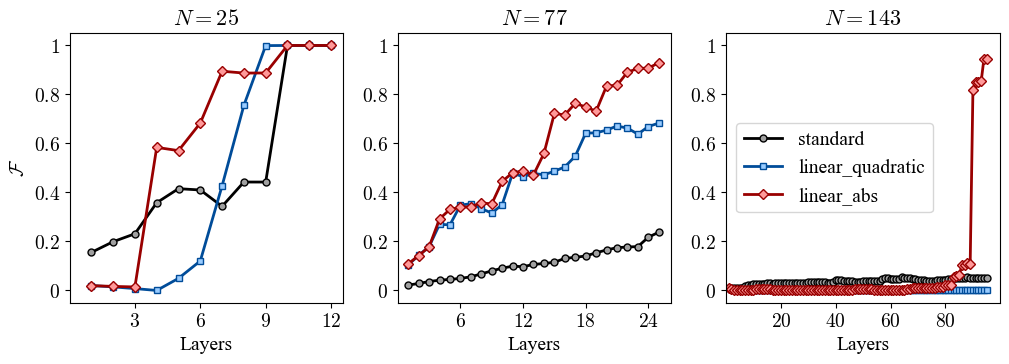

In [38]:
Ns = [25, 77, 143]

fidelity_threshold = 0.8

ncols = 3
nrows = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey=False)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
        .reset_index().loc[0,'layers'] + 5
    
    df_N = df_N[df_N['layers']<=max_layers]

    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('Layers')
    if i==0:
        ax.set_ylabel('$\mathcal{F}$')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax.set_xlim(0.001)
    ax.set_ylim(-0.05,1.05)

    if i==2:
        ax.legend(loc='center left')

# handles, labels = ax.get_legend_handles_labels()
# plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.15), ncol=3);

# plt.savefig(f"plots/fidelity_layers_{''.join([str(N) for N in Ns])}.pdf", format='pdf', bbox_inches='tight')

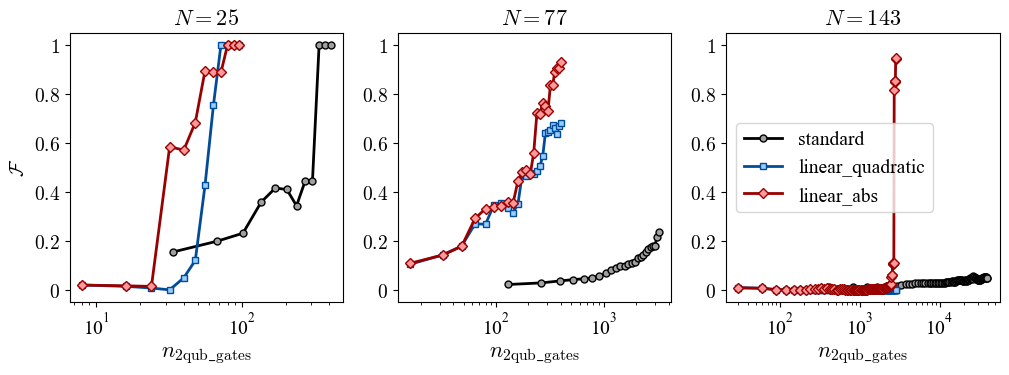

In [39]:
Ns = [25, 77, 143]

fidelity_threshold = 0.8

ncols = 3
nrows = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey=False)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
        .reset_index().loc[0,'layers'] + 5
    
    df_N = df_N[df_N['layers']<=max_layers]

    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'num_2qub_gates', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('$n_\\mathrm{2qub\_gates}$', fontsize=16)
    if i==0:
        ax.set_ylabel('$\mathcal{F}$', fontsize=14)

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax.set_ylim(-0.05,1.05)
    ax.set_xscale('log')

    if i==2:
        ax.legend(loc='center left')

# handles, labels = ax.get_legend_handles_labels()
# plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.15), ncol=3);

# plt.savefig(f"plots/fidelity_gates_{''.join([str(N) for N in Ns])}.pdf", format='pdf', bbox_inches='tight')

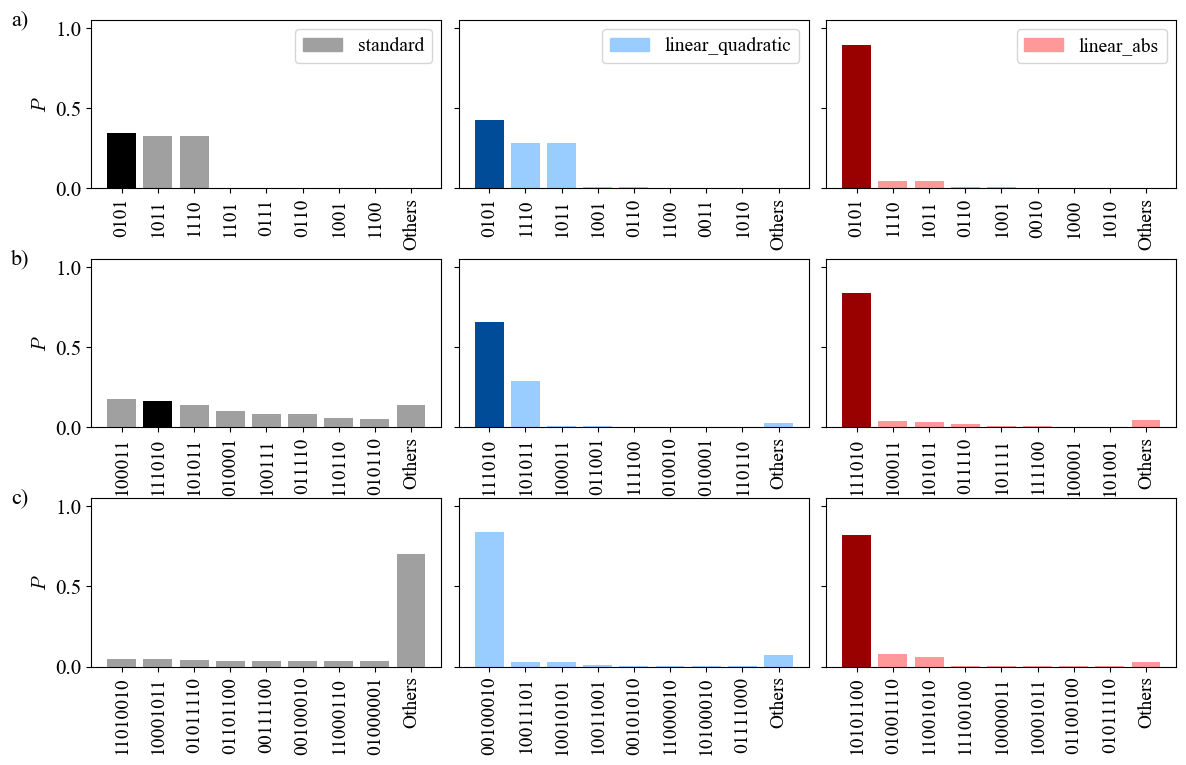

In [40]:
Ns = [25, 77, 143]

ncols = 3
nrows = len(Ns)

fig, axs = plt.subplots(nrows, ncols, figsize=(14, 2.8*nrows), sharey=True)
fig.subplots_adjust(hspace=0.42, wspace=0.05)

for i, N in enumerate(Ns):
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        ax = axs[i][j]
        df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
        max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
            .reset_index().loc[0,'layers']
        df = df_N[(df_N['layers']==max_layers) & (df_N['setup']==protocol)].reset_index()
        
        probs = np.array(df.loc[0, 'populations'])
        num_qubits = df.loc[0, 'num_qubits']
        solutions = df.loc[0, 'solution']
        x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
        idx_sorted = np.argsort(probs)[::-1]
        
        # Select top 8
        top_k = 8
        idx_top = idx_sorted[:top_k]
        idx_rest = idx_sorted[top_k:]
        
        # Build reduced x and y
        x_top = [x_hist[k] for k in idx_top]
        y_top = probs[idx_top]
        
        # Add the "Others" bar
        x_plot = x_top + ['Others']
        y_plot = list(y_top) + [probs[idx_rest].sum()]
        
        # Colors: dark if solution, light otherwise, gray for "Others"
        bar_colors = [
            plot_colors[j][0] if label in solutions else plot_colors[j][1]
            for label in x_top
        ] + [plot_colors[j][1]]  # gray for "Others"

        ax.bar(x_plot, y_plot, color=bar_colors, label=protocol)
        ax.xaxis.set_tick_params(rotation=90, labelsize=14)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.set_ylim(0,1.05)
        if j==0:
            ax.set_ylabel('$P$')

        if i==0:
            light_patch = Patch(color=plot_colors[j][1], label=protocol)
            ax.legend(handles=[light_patch])

row_labels = ['a)', 'b)', 'c)']
for i, label in enumerate(row_labels):
    ax = axs[i, 0]  # first column of each row
    ax.text(-0.18, 1, label, transform=ax.transAxes,
            fontsize=16, va='center', ha='right', fontfamily='Times New Roman')

# plt.savefig(f"plots/populations_{''.join([str(N) for N in Ns])}.pdf", format='pdf', bbox_inches='tight')


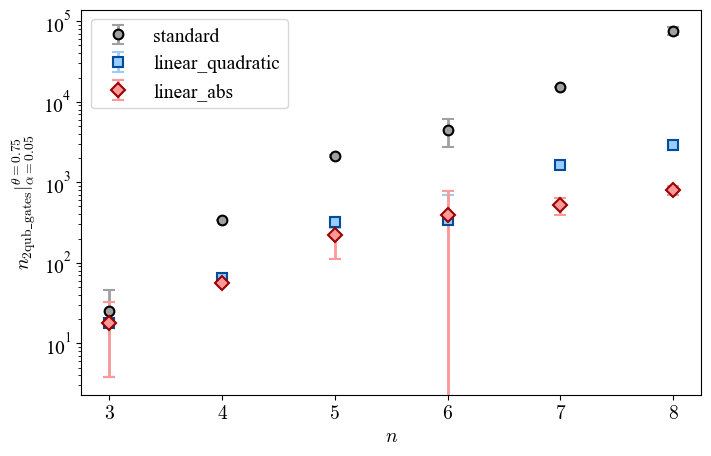

In [41]:
alpha = 0.05
threshold = 0.75

def compute_m_closest(row, alpha):
    Ep = np.array(row['Ep'])
    populations = np.array(row['populations'])
    n_states = len(Ep)
    k = max(1, int(np.ceil(alpha * n_states)))  # number of states to include

    # sort indices by closeness to zero energy
    idx = np.argsort(np.abs(Ep))
    closest_idx = idx[:k]
    return populations[closest_idx].sum()

df = experiment_results[(experiment_results['optimizer']=='BFGS')&(experiment_results['N']!=143)].copy()
# Add the column
df[f'm_closest_{alpha}'] = df.apply(lambda row: compute_m_closest(row, alpha), axis=1)

df = df[['N', 'num_qubits', 'layers', 'num_2qub_gates', 'setup', 'relative_cost',
         'fidelity', f'm_closest_{alpha}']]
df = df[df[f'm_closest_{alpha}'] >= threshold]
df = df.groupby(['N','num_qubits','setup']).agg({
    'layers': 'min',
    'num_2qub_gates': 'min',
    f'm_closest_{alpha}': 'first'
}).reset_index()

df = df.groupby(['num_qubits', 'setup']).agg({
    'num_2qub_gates': ['mean', 'std'],
}).fillna(0).reset_index()

df.columns = ['num_qubits', 'setup', 'mean_gates', 'std_gates']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, setup in enumerate(['standard','linear_quadratic','linear_abs']):
    ax.errorbar('num_qubits', 'mean_gates', yerr='std_gates', data=df[df['setup']==setup],
                label=setup, linestyle='none', capsize=4, linewidth=2,
               color=plot_colors[i][1], marker=markers[i], markersize=7,
               markeredgecolor=plot_colors[i][0], markerfacecolor=plot_colors[i][1])
    
ax.legend(loc='best')
ax.set_xlabel('$n$')
ax.set_ylabel('$n_\\mathrm{2qub\_gates}|_{\\alpha=0.05}^{\\theta=0.75}$')
ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)
ax.set_yscale('log')

# plt.savefig(f"plots/accumulated_probability.pdf", format='pdf', bbox_inches='tight')

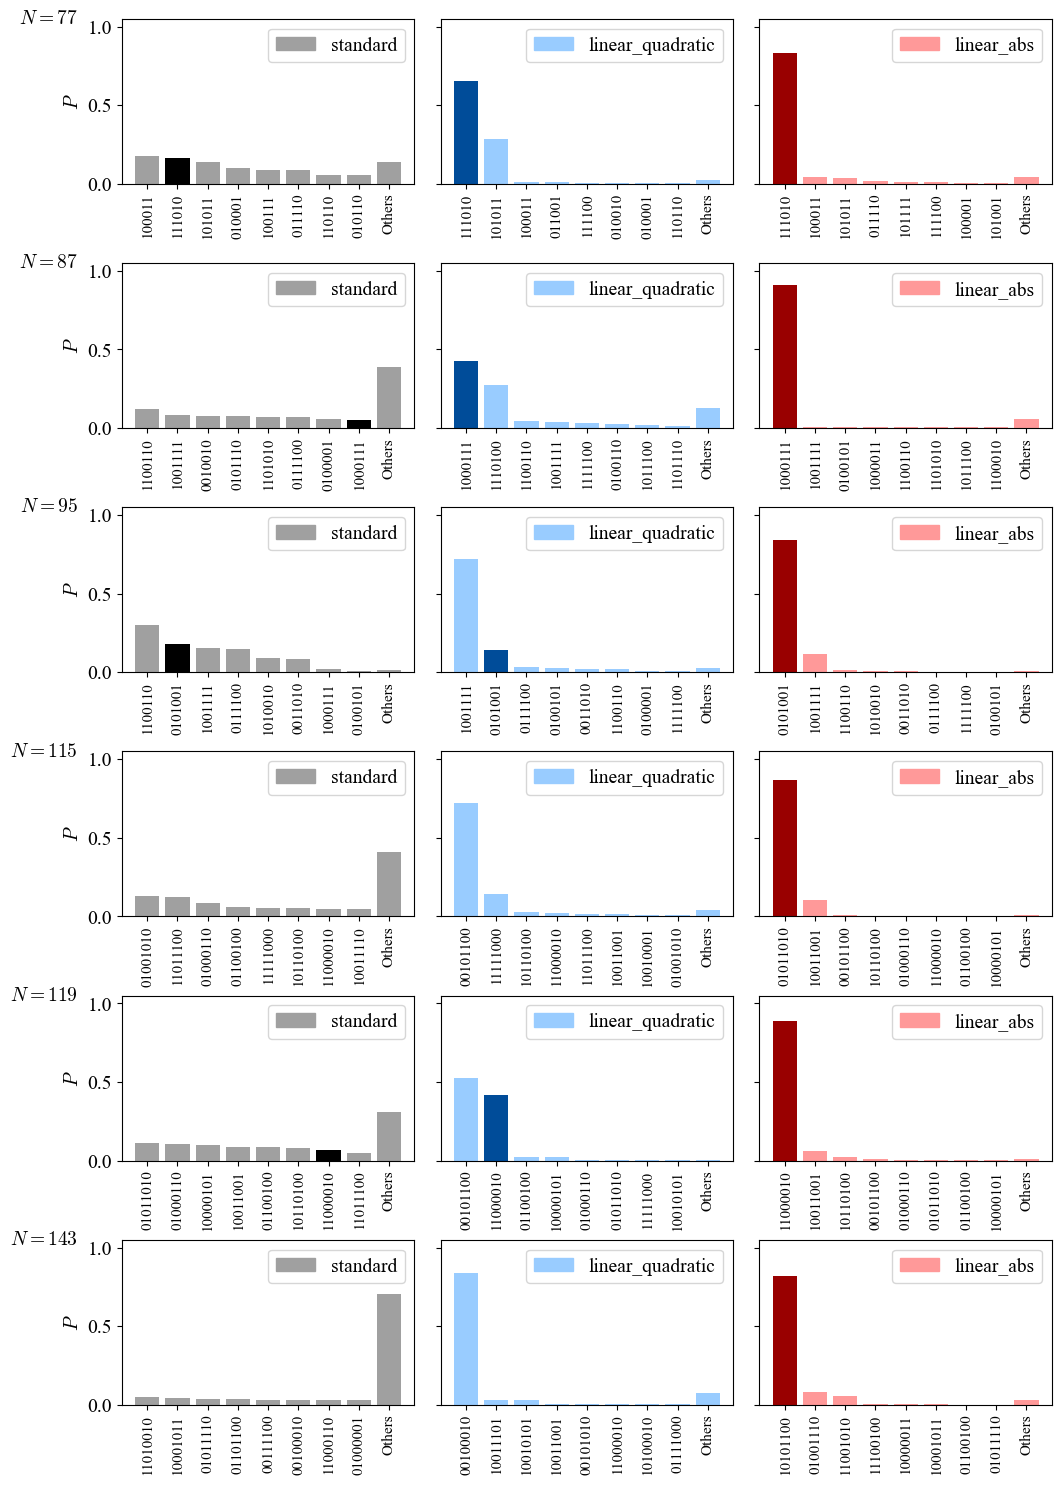

In [42]:
Ns = sorted(experiment_results['N'].unique())[6:]

ncols = 3
nrows = len(Ns)

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3*nrows), sharey=True)
fig.subplots_adjust(hspace=0.48, wspace=0.09)

for i, N in enumerate(Ns):
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        ax = axs[i][j]
        df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
        max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
            .reset_index().loc[0,'layers']
        df = df_N[(df_N['layers']==max_layers) & (df_N['setup']==protocol)].reset_index()
        
        probs = np.array(df.loc[0, 'populations'])
        num_qubits = df.loc[0, 'num_qubits']
        solutions = df.loc[0, 'solution']
        x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
        idx_sorted = np.argsort(probs)[::-1]
        
        # Select top 8
        top_k = 8
        idx_top = idx_sorted[:top_k]
        idx_rest = idx_sorted[top_k:]
        
        # Build reduced x and y
        x_top = [x_hist[k] for k in idx_top]
        y_top = probs[idx_top]
        
        # Add the "Others" bar
        x_plot = x_top + ['Others']
        y_plot = list(y_top) + [probs[idx_rest].sum()]
        
        # Colors: dark if solution, light otherwise, gray for "Others"
        bar_colors = [
            plot_colors[j][0] if label in solutions else plot_colors[j][1]
            for label in x_top
        ] + [plot_colors[j][1]]  # gray for "Others"

        ax.bar(x_plot, y_plot, color=bar_colors, label=protocol)
        ax.xaxis.set_tick_params(rotation=90, labelsize=11)
        ax.set_ylim(0,1.05)
        if j==0:
            ax.set_ylabel('$P$')

        light_patch = Patch(color=plot_colors[j][1], label=protocol)
        ax.legend(handles=[light_patch])

for i, label in enumerate(Ns):
    label = f'$N={label}$'
    ax = axs[i, 0]  # first column of each row
    ax.text(-0.15, 1, label, transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='center', ha='right', fontfamily='Times New Roman')

# plt.savefig(f"plots/populations_all2.pdf", format='pdf', bbox_inches='tight')


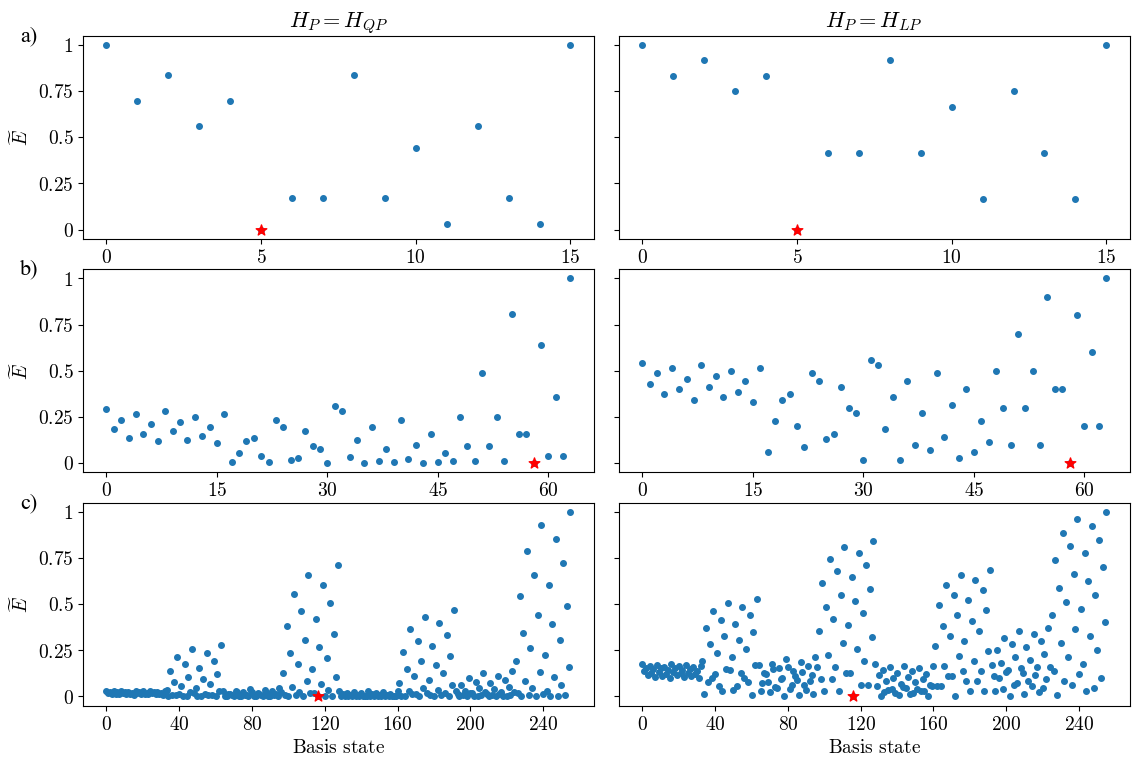

In [43]:
Ns = [25, 77, 143]

fig, axs = plt.subplots(len(Ns), 2, figsize=(13.5,2.9*len(Ns)), sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.15)

for i, N in enumerate(Ns):
    for j, setup in enumerate(['standard', 'linear_quadratic']):
        ax = axs[i][j]
        df = experiment_results[(experiment_results['N']==N)
                                &(experiment_results['setup']==setup)
                                & (experiment_results['optimizer']=='BFGS')].reset_index()
        Ep = df.loc[0,'Ep']
        R = np.max(np.abs(Ep))
        normalized_Ep = np.abs(Ep)/R
        title = f'$H_P=H_{{{"Q" if setup=="standard" else "L"}P}}$'
        ax.scatter(range(len(Ep)), normalized_Ep, s=16)

        sol = list(normalized_Ep).index(0)
        ax.scatter(sol, 0, s=64, color='red', marker='*')

        if i==0:
            ax.set_title(title)
        if j==0:
            ax.set_ylabel('$\\widetilde{E}$')
        if i==len(Ns)-1:
            ax.set_xlabel('$\\text{Basis state}$')

        ax.xaxis.set_major_formatter(ticks_formatter)
        ax.yaxis.set_major_formatter(ticks_formatter)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=np.log2(len(Ep)), integer=True))

row_labels = ['a)', 'b)', 'c)']
for i, label in enumerate(row_labels):
    ax = axs[i, 0]  # first column of each row
    ax.text(-0.09, 1, label, transform=ax.transAxes,
            fontsize=16, va='center', ha='right', fontfamily='Times New Roman')

# plt.savefig(f"plots/energy_spectrums.pdf", format='pdf', bbox_inches='tight')

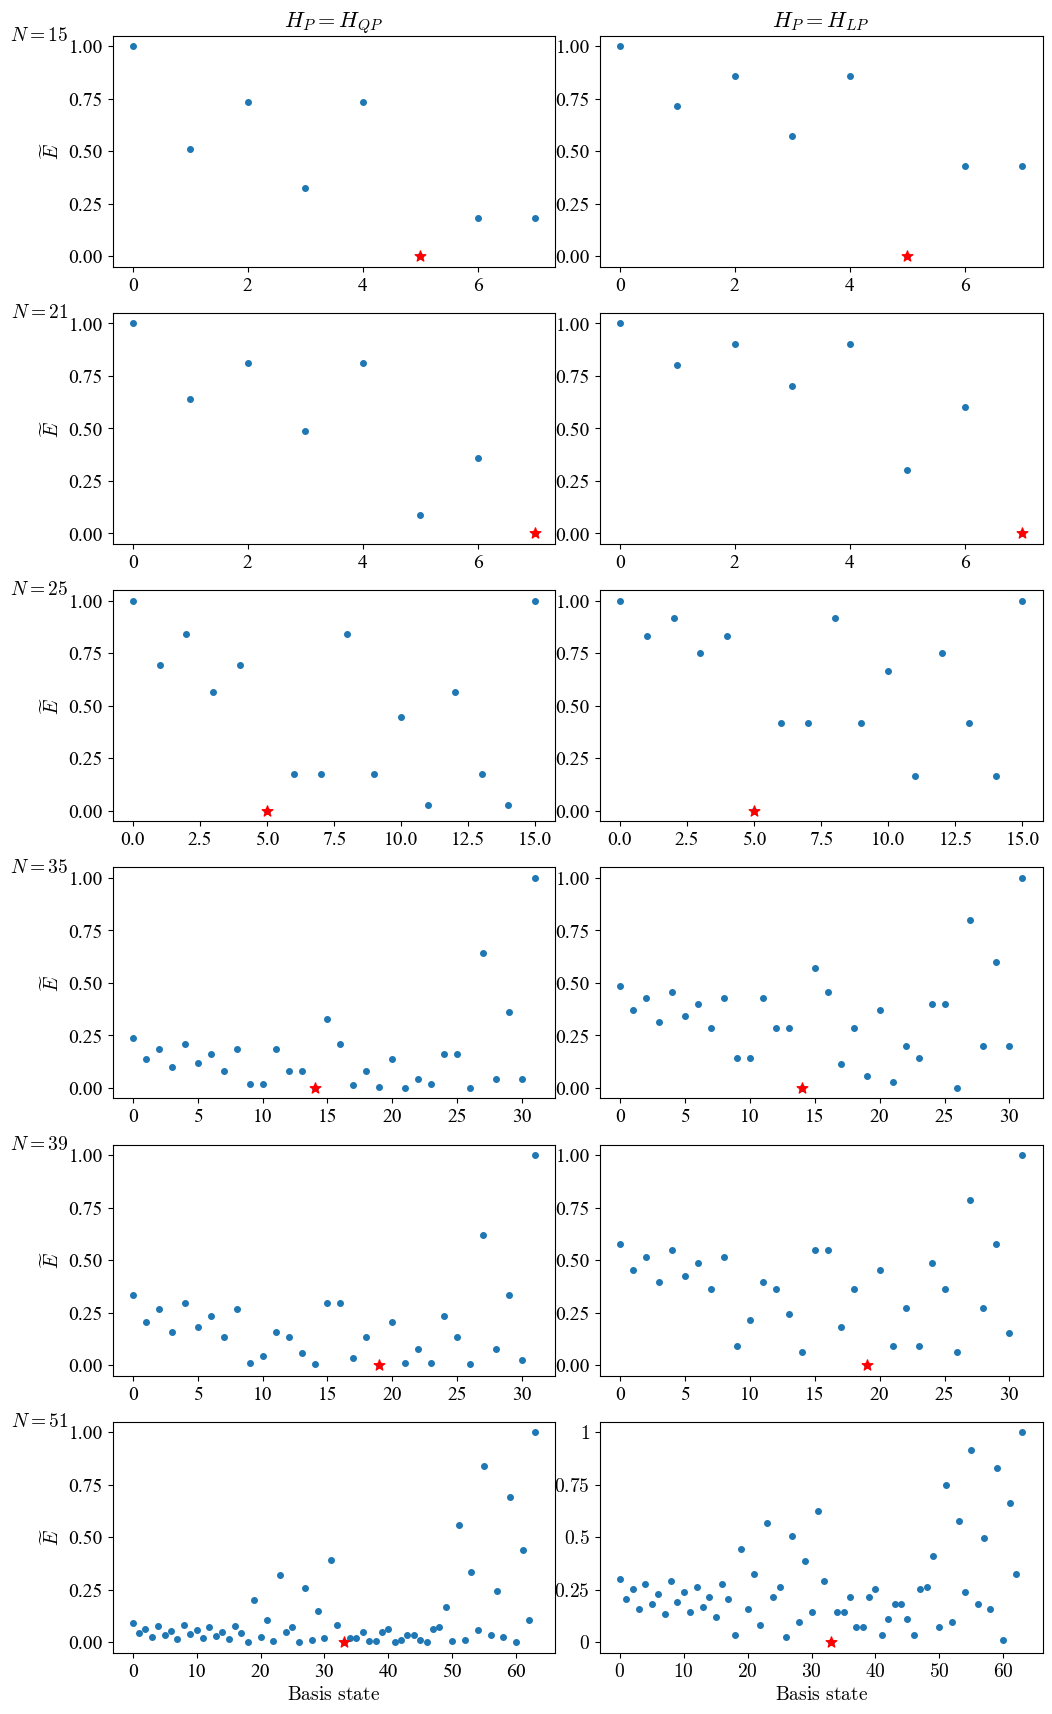

In [44]:
Ns = sorted(experiment_results['N'].unique())[:6]

fig, axs = plt.subplots(len(Ns), 2, figsize=(12,3.5*len(Ns)))
fig.subplots_adjust(wspace=0.1, hspace=0.2)

for i, N in enumerate(Ns):
    for j, setup in enumerate(['standard', 'linear_quadratic']):
        ax = axs[i][j]
        df = experiment_results[(experiment_results['N']==N)
                                &(experiment_results['setup']==setup)
                                & (experiment_results['optimizer']=='BFGS')].reset_index()
        Ep = df.loc[0,'Ep']
        R = np.max(np.abs(Ep))
        normalized_Ep = np.abs(Ep)/R
        title = f'$H_P=H_{{{"Q" if setup=="standard" else "L"}P}}$'
        ax.scatter(range(len(Ep)), normalized_Ep, s=16)

        sol = list(normalized_Ep).index(0)
        ax.scatter(sol, 0, s=64, color='red', marker='*')

        if i==0:
            ax.set_title(title)
        if j==0:
            ax.set_ylabel('$\\widetilde{E}$')
        if i==len(Ns)-1:
            ax.set_xlabel('$\\text{Basis state}$')

ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)

for i, label in enumerate(Ns):
    label = f'$N={label}$'
    ax = axs[i, 0]  # first column of each row
    ax.text(-0.1, 1, label, transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='center', ha='right', fontfamily='Times New Roman')

# plt.savefig(f"plots/energy_spectrums_all1.pdf", format='pdf', bbox_inches='tight')